#  Linear Regression - Used Automobile Prices

#  Charles Kilpatrick January 28, 2023

## Context

There is a huge demand for used cars in the Indian Market today. As sales of new cars have slowed down in the recent past, the pre-owned car market has continued to grow over the past years and is larger than the new car market now. Cars4U is a budding tech start-up that aims to find footholes in this market.

In 2018-19, while new car sales were recorded at 3.6 million units, around 4 million second-hand cars were bought and sold. There is a slowdown in new car sales and that could mean that the demand is shifting towards the pre-owned market. In fact, some car sellers replace their old cars with pre-owned cars instead of buying new ones. Unlike new cars, where price and supply are fairly deterministic and managed by OEMs (Original Equipment Manufacturer / except for dealership level discounts which come into play only in the last stage of the customer journey), used cars are very different beasts with huge uncertainty in both pricing and supply. Keeping this in mind, the pricing scheme of these used cars becomes important in order to grow in the market.

As a senior data scientist at Cars4U, you have to come up with a pricing model that can effectively predict the price of used cars and can help the business in devising profitable strategies using differential pricing. For example, if the business knows the market price, it will never sell anything below it.


## Objective

To explore and visualize the dataset, build a linear regression model to predict the prices of used cars, and generate a set of insights and recommendations that will help the business.

## Problem Definition, Background and Contents

The object of this project is to develop a regression model for used car prices in the Indian market
to allow a startup to enter this area and to expand by having superior knowledge of the market price for used cars.

## Data Description

The data contains the different attributes of used cars sold in different locations. The detailed data dictionary is given below.

## Data Dictionary

- S.No.: Serial number
- Name: Name of the car which includes brand name and model name
- Location: Location in which the car is being sold or is available for purchase (cities)
- Year: Manufacturing year of the car
- Kilometers_driven: The total kilometers driven in the car by the previous owner(s) in km
- Fuel_Type: The type of fuel used by the car (Petrol, Diesel, Electric, CNG, LPG)
- Transmission: The type of transmission used by the car (Automatic/Manual)
- Owner_Type: Type of ownership
- Mileage: The standard mileage offered by the car company in kmpl or km/kg
- Engine: The displacement volume of the engine in CC
- Power: The maximum power of the engine in bhp
- Seats: The number of seats in the car
- New_Price: The price of a new car of the same model in INR Lakhs (1 Lakh = 100,000 INR)
- Price: The price of the used car in INR Lakhs

In [1]:
# This will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to split the data into train and test
from sklearn.model_selection import train_test_split

# to build linear regression_model
from sklearn.linear_model import LinearRegression

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [3]:
# Function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [4]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [5]:
#!pip install mlxtend

In [6]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

## Loading and Exploring the Data

- In this section the goals are to load the data into python and then to check its basic properties. This will include the
  dimension, column types and names, and missingness counts.

In [7]:
#Read the data set into a Pandas dataframe
dataframe = pd.read_csv("used_cars_data.csv")

In [8]:
# Make a copy of the dataframe
df = dataframe.copy()

In [9]:
# Investigate dataframe shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")  # f-string

There are 7253 rows and 14 columns.


In [10]:
#Initial exploration of dataframe
df.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,5.51,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,16.06,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,11.27,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,53.14,17.74


In [11]:
# Set the random seed via np.random.seed for consistent random sampling
np.random.seed(1)
# sample 10 random rows
df.sample(n=10)

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
2397,2397,Ford EcoSport 1.5 Petrol Trend,Kolkata,2016,21460,Petrol,Manual,First,17.0 kmpl,1497 CC,121.36 bhp,5.0,9.47,6.00
3777,3777,Maruti Wagon R VXI 1.2,Kochi,2015,49818,Petrol,Manual,First,21.5 kmpl,1197 CC,81.80 bhp,5.0,5.44,4.11
4425,4425,Ford Endeavour 4x2 XLT,Hyderabad,2007,130000,Diesel,Manual,First,13.1 kmpl,2499 CC,141 bhp,7.0,35.29,6.00
3661,3661,Mercedes-Benz E-Class E250 CDI Avantgrade,Coimbatore,2016,39753,Diesel,Automatic,First,13.0 kmpl,2143 CC,201.1 bhp,5.0,86.97,35.28
4514,4514,Hyundai Xcent 1.2 Kappa AT SX Option,Kochi,2016,45560,Petrol,Automatic,First,16.9 kmpl,1197 CC,82 bhp,5.0,8.23,6.34
599,599,Toyota Innova Crysta 2.8 ZX AT,Coimbatore,2019,40674,Diesel,Automatic,First,11.36 kmpl,2755 CC,171.5 bhp,7.0,28.05,24.82
186,186,Mercedes-Benz E-Class E250 CDI Avantgrade,Bangalore,2014,37382,Diesel,Automatic,First,13.0 kmpl,2143 CC,201.1 bhp,5.0,86.97,32.00
305,305,Audi A6 2011-2015 2.0 TDI Premium Plus,Kochi,2014,61726,Diesel,Automatic,First,17.68 kmpl,1968 CC,174.33 bhp,5.0,67.10,20.77
4582,4582,Hyundai i20 1.2 Magna,Kolkata,2011,36000,Petrol,Manual,First,18.5 kmpl,1197 CC,80 bhp,5.0,10.25,2.50
5434,5434,Honda WR-V Edge Edition i-VTEC S,Kochi,2019,13913,Petrol,Manual,First,17.5 kmpl,1199 CC,88.7 bhp,5.0,9.36,8.20


In [12]:
# Print last 5 rows
df.tail()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
7248,7248,Volkswagen Vento Diesel Trendline,Hyderabad,2011,89411,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.0,13.23,NaN
7249,7249,Volkswagen Polo GT TSI,Mumbai,2015,59000,Petrol,Automatic,First,17.21 kmpl,1197 CC,103.6 bhp,5.0,10.15,NaN
7250,7250,Nissan Micra Diesel XV,Kolkata,2012,28000,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,9.47,NaN
7251,7251,Volkswagen Polo GT TSI,Pune,2013,52262,Petrol,Automatic,Third,17.2 kmpl,1197 CC,103.6 bhp,5.0,10.15,NaN
7252,7252,Mercedes-Benz E-Class 2009-2013 E 220 CDI Avan...,Kochi,2014,72443,Diesel,Automatic,First,10.0 kmpl,2148 CC,170 bhp,5.0,86.97,NaN


In [13]:
#Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7078 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          7253 non-null   float64
 13  Price              6019 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 793.4+ KB


In [14]:
#Check for null values
df.isnull().sum().sort_values(ascending=False)

Price                1234
Power                 175
Seats                  53
Engine                 46
Mileage                 2
S.No.                   0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
New_Price               0
dtype: int64

In [15]:
#Check for duplicated values
df.duplicated().sum()

0

In [16]:
# Dataframe descriptive statistics
df.describe(include="all").T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
S.No.,7253.0,NaN,NaN,NaN,3626.0,2093.905084,0.0,1813.0,3626.0,5439.0,7252.0
Name,7253,2041,Mahindra XUV500 W8 2WD,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,7253,11,Mumbai,949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,7253.0,NaN,NaN,NaN,2013.365366,3.254421,1996.0,2011.0,2014.0,2016.0,2019.0
Kilometers_Driven,7253.0,NaN,NaN,NaN,58699.063146,84427.720583,171.0,34000.0,53416.0,73000.0,6500000.0
Fuel_Type,7253,5,Diesel,3852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,7253,2,Manual,5204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner_Type,7253,4,First,5952,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,7251,450,17.0 kmpl,207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine,7207,150,1197 CC,732,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

### Univariate Analysis

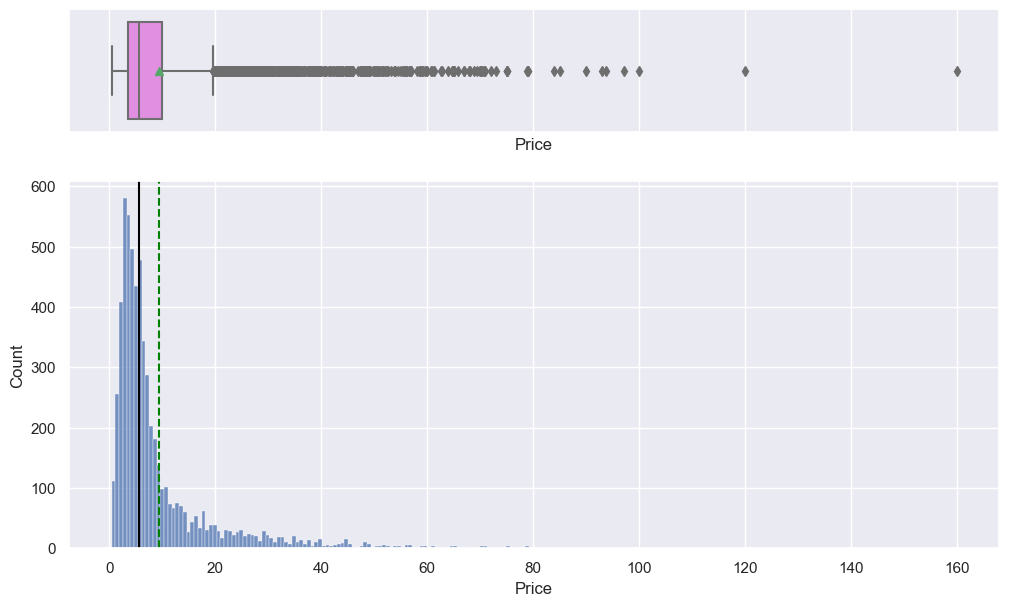

In [17]:
#Boxplot and histogram for price variable
histogram_boxplot(df, "Price")

In [18]:
# Remove all rows where price value is missing
df.dropna(subset=["Price"], how="any", inplace=True)

<Axes: xlabel='S.No.', ylabel='Price'>

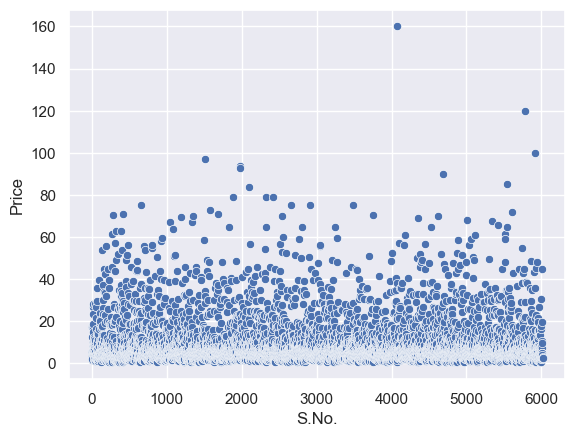

In [19]:
# Make scatterplot of price and serial number to investigate dropping serial number from dataframe
sns.scatterplot(data=df, x="S.No.", y="Price")

### Observation

- Serial number will be dropped from data frame as there is no meaningful correlation with price

In [20]:
# Remove serial number from dataframe
df.drop(["S.No."], axis=1, inplace=True)

In [21]:
#Investigate seats variable
print(df["Seats"].value_counts())

5.0     5014
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
0.0        1
Name: Seats, dtype: int64


In [22]:
# Insert median for missing seats values
df["Seats"] = df["Seats"].fillna(df["Seats"].median())

In [23]:
#Check basic statistics
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,6019,1876,Mahindra XUV500 W8 2WD,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,6019,11,Mumbai,790,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,6019.0,NaN,NaN,NaN,2013.358199,3.269742,1998.0,2011.0,2014.0,2016.0,2019.0
Kilometers_Driven,6019.0,NaN,NaN,NaN,58738.380296,91268.843206,171.0,34000.0,53000.0,73000.0,6500000.0
Fuel_Type,6019,5,Diesel,3205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,6019,2,Manual,4299,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner_Type,6019,4,First,4929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,6017,442,18.9 kmpl,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine,5983,146,1197 CC,606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,5876,371,74 bhp,235,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Make a copy of the dataframe
df1 = df.copy()

In [25]:
# Strip blanks out of engine object
df1["Engine"] = df1["Engine"].str.strip()

In [26]:
# Print the names of the columns where there is
# at least one entry ending with the characters "CC"

eng_cc = []
for colname in df1.columns[df1.dtypes == "object"]:
    if df1[colname].str.endswith("CC").any():
        eng_cc.append(colname)
print(eng_cc)

['Engine']


In [27]:
#Define function for converting engine displacement to numerical
def engine_to_num(engine_val):
    """This function manipulates a string representing engine displacement in cc
    and converts it to a number. For example, '1200 CC' becomes 1200.
    If the input is already numeric, which probably means it's NaN,
    this function returns np.nan."""
    if isinstance(engine_val, str):  # checks if `engine_val` is a string
        return float(engine_val.replace("CC", " "))
    else:  # this happens when the engine displacement is np.nan
        return np.nan

In [28]:
#Apply function for converting engine value to numeric
df1["Engine"] = df1["Engine"].apply(engine_to_num)

In [29]:
# Insert median for missing engine values
df1["Engine"] = df1["Engine"].fillna(df1["Engine"].median())

In [30]:
# Strip blanks out of power object
df1["Power"] = df1["Power"].str.strip()

In [31]:
# Print the names of the columns where there is
# at least one entry ending with the characters "CC"
power_bhp = []
for colname in df1.columns[df1.dtypes == "object"]:
    if df1[colname].str.endswith("bhp").any():
        power_bhp.append(colname)
print(power_bhp)

['Power']


In [32]:
#Define function to convert power to numeric
def power_to_num(power_val):
    """This function manipulates a string representing power in bhp
    and converts it to a number. For example, '100 bhp' becomes 100.
    If the input is already numeric, which probably means it's NaN,
    this function returns np.nan."""
    if isinstance(power_val, str):  # checks if `engine_val` is a string
        return float(power_val.replace("bhp", " "))
    else:  # this happens when the engine displacement is np.nan
        return np.nan


In [33]:
#Apply function to convert power to numeric
df1["Power"] = df1["Power"].apply(power_to_num)

In [34]:
# Insert median for missing power values
df1["Power"] = df1["Power"].fillna(df1["Power"].median())


In [35]:
#Make copy of dataframe
df2 = df1.copy()

In [36]:
# Investigate Fuel_Type parameter
print(df2["Fuel_Type"].value_counts())

Diesel      3205
Petrol      2746
CNG           56
LPG           10
Electric       2
Name: Fuel_Type, dtype: int64


### Observations

- Remove vehicles fueled by CNG, LPG, and electric from dataframe.  This is a very small fraction of vehicles sold and
  including these vehicles could skew the mode results.  Public buses are often fueled by CNG which could account for the
  vehicles with a large number of seats. All three of these types of vehicles require special infrastructure for fueling or
  electrical charging.  This would cause an unrealistic modeling favoring large cities where the infrastructure is availabe.
  Removing these small numbers of higher priced, less common specialized vehicles will improve price modeling precision for
  gasoline and diesel powered vehicle which are the main market for the company.

In [37]:
#Drop CNG from fuel type
df2.drop(df2.index[df2["Fuel_Type"] == "CNG"], inplace=True)

In [38]:
#Drop LPG from fuel type
df2.drop(df2.index[df2["Fuel_Type"] == "LPG"], inplace=True)

In [39]:
# Drop electric vehicles
df2.drop(df2.index[df2["Fuel_Type"] == "Electric"], inplace=True)

In [40]:
# Investigate Location values
print(df2["Location"].value_counts())

Mumbai        771
Hyderabad     733
Kochi         643
Coimbatore    636
Pune          608
Delhi         544
Kolkata       535
Chennai       491
Jaipur        411
Bangalore     358
Ahmedabad     221
Name: Location, dtype: int64


### Observation

- Mumbai and Hydrabad are the largest volume markets

In [41]:
# Investigate Transmission values
print(df2["Transmission"].value_counts())

Manual       4233
Automatic    1718
Name: Transmission, dtype: int64


In [42]:
#Investigate Owner_Type values
print(df2["Owner_Type"].value_counts())


First             4874
Second             956
Third              112
Fourth & Above       9
Name: Owner_Type, dtype: int64


In [43]:
#Check dataframe statistics again
df2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,5951,1847,Mahindra XUV500 W8 2WD,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,5951,11,Mumbai,771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,5951.0,NaN,NaN,NaN,2013.356411,3.275297,1998.0,2011.0,2014.0,2016.0,2019.0
Kilometers_Driven,5951.0,NaN,NaN,NaN,58771.243488,91758.988877,171.0,33965.5,53000.0,73000.0,6500000.0
Fuel_Type,5951,2,Diesel,3205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,5951,2,Manual,4233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner_Type,5951,4,First,4874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,5951,418,17.0 kmpl,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine,5951.0,NaN,NaN,NaN,1626.718535,599.611035,624.0,1198.0,1493.0,1984.0,5998.0
Power,5951.0,NaN,NaN,NaN,113.437989,53.304703,34.2,78.9,97.7,138.1,560.0


In [44]:
#Check dataframe head
df2.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582.0,126.20,5.0,16.06,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199.0,88.70,5.0,8.61,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248.0,88.76,7.0,11.27,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968.0,140.80,5.0,53.14,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461.0,63.10,5.0,9.47,3.50


In [45]:
#Random sample of dataframe
df2.sample(10)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
4840,Maruti Alto LXi BSII,Mumbai,2008,54000,Petrol,Manual,First,19.7 kmpl,796.0,46.30,5.0,4.360,1.10
5323,Ford Endeavour 3.2 Titanium AT 4X4,Chennai,2017,17000,Diesel,Automatic,First,10.91 kmpl,3198.0,197.00,7.0,35.290,31.00
2983,Honda City ZX GXi,Pune,2008,119000,Petrol,Manual,Second,17.7 kmpl,1497.0,78.00,5.0,13.580,2.25
3307,Toyota Etios Liva GD,Delhi,2013,64000,Diesel,Manual,First,23.59 kmpl,1364.0,67.06,5.0,8.525,3.10
1873,Maruti Ciaz ZXi,Delhi,2017,17000,Petrol,Manual,First,20.73 kmpl,1373.0,91.10,5.0,11.110,7.65
5325,Maruti Swift VDI,Kochi,2016,65210,Diesel,Manual,First,22.9 kmpl,1248.0,74.00,5.0,7.880,5.48
1341,Maruti Ciaz ZDi Plus SHVS,Jaipur,2015,40500,Diesel,Manual,First,28.09 kmpl,1248.0,88.50,5.0,11.110,7.10
1430,Ford Endeavour 3.2 Trend AT 4X4,Kochi,2018,30552,Diesel,Automatic,First,10.91 kmpl,3198.0,197.20,7.0,35.290,32.44
4825,Hyundai Creta 1.6 VTVT S,Bangalore,2016,40000,Petrol,Manual,First,15.29 kmpl,1591.0,121.30,5.0,16.060,11.50
4607,Hyundai i20 Magna,Jaipur,2013,59000,Petrol,Manual,Second,18.5 kmpl,1197.0,80.00,5.0,10.250,4.10


In [46]:
#Check dataframe tail
df2.tail()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
6014,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.4 kmpl,1248.0,74.0,5.0,7.88,4.75
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.4 kmpl,1120.0,71.0,5.0,8.23,4.00
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.0 kmpl,2498.0,112.0,8.0,11.67,2.90
6017,Maruti Wagon R VXI,Kolkata,2013,46000,Petrol,Manual,First,18.9 kmpl,998.0,67.1,5.0,5.51,2.65
6018,Chevrolet Beat Diesel,Hyderabad,2011,47000,Diesel,Manual,First,25.44 kmpl,936.0,57.6,5.0,11.30,2.50


In [47]:
#Make dataframe copy
df3 = df2.copy()

In [48]:
# Determine number of mileage NaN values
df3["Mileage"].isna().sum()

0

In [49]:
# Strip blanks out of mileage object
df2["Mileage"] = df2["Mileage"].str.strip()

In [50]:
# Print the names of the columns where there is
# at least one entry ending with the characters "kmpl"
mile_kmpl = []
for colname in df2.columns[df2.dtypes == "object"]:
    if df2[colname].str.endswith("kmpl").any():
        mile_kmpl.append(colname)
print(mile_kmpl)

['Mileage']


In [51]:
#Define function to convert mile data to numeric
def mile_to_num(mile_val):
    """This function manipulates a string representing mileage in kmpl
    and converts it to a number. 
    If the input is already numeric, which probably means it's NaN,
    this function returns np.nan."""
    if isinstance(mile_val, str):  # checks if `engine_val` is a string
        return float(mile_val.replace("kmpl", " "))
    else:
        return np.nan

In [52]:
#Apply function to convert mile data to numeric
df3["Mileage"] = df3["Mileage"].apply(mile_to_num)

In [53]:
# Check dataframe descriptive information
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5951 entries, 1 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5951 non-null   object 
 1   Location           5951 non-null   object 
 2   Year               5951 non-null   int64  
 3   Kilometers_Driven  5951 non-null   int64  
 4   Fuel_Type          5951 non-null   object 
 5   Transmission       5951 non-null   object 
 6   Owner_Type         5951 non-null   object 
 7   Mileage            5951 non-null   float64
 8   Engine             5951 non-null   float64
 9   Power              5951 non-null   float64
 10  Seats              5951 non-null   float64
 11  New_Price          5951 non-null   float64
 12  Price              5951 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 650.9+ KB


In [54]:
#Recheck for null values
df3.isnull().sum().sort_values(ascending=False)

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
New_Price            0
Price                0
dtype: int64

In [55]:
# Convert Kilometers_Driven to float
df3["Kilometers_Driven"] = df3["Kilometers_Driven"].astype(float)

In [56]:
#Split name string
df3["Make"] = df3["Name"].str.split(" ").str[0]

In [57]:
df3.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000.0,Diesel,Manual,First,19.67,1582.0,126.20,5.0,16.06,12.50,Hyundai
2,Honda Jazz V,Chennai,2011,46000.0,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61,4.50,Honda
3,Maruti Ertiga VDI,Chennai,2012,87000.0,Diesel,Manual,First,20.77,1248.0,88.76,7.0,11.27,6.00,Maruti
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670.0,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,53.14,17.74,Audi
6,Nissan Micra Diesel XV,Jaipur,2013,86999.0,Diesel,Manual,First,23.08,1461.0,63.10,5.0,9.47,3.50,Nissan


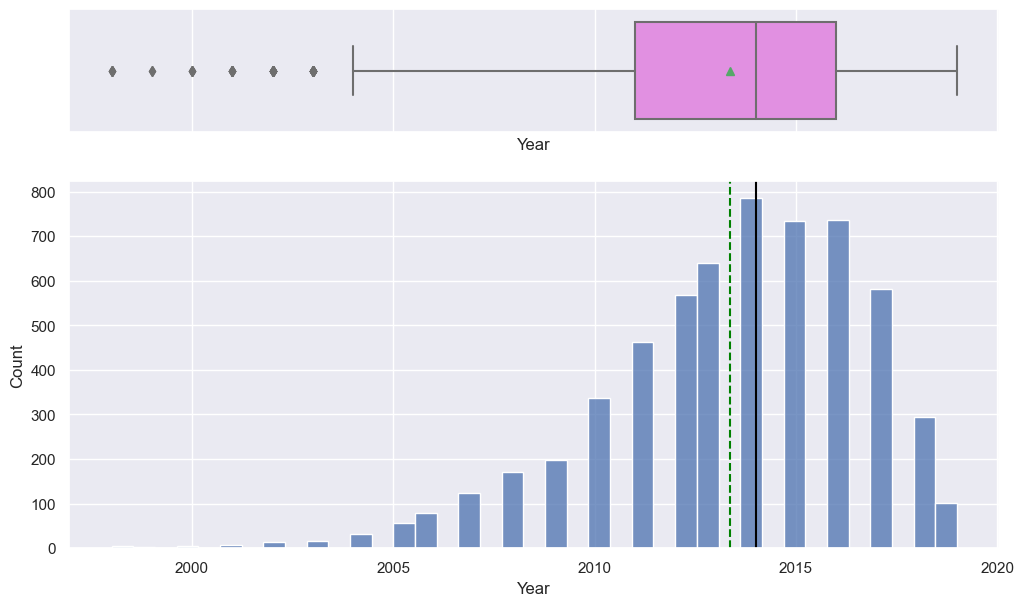

In [58]:
histogram_boxplot(df3, "Year")

### Observations

- Year data is left skewed 
- Left whisker value equals 2011 - 1.5 * 5 (IQR) = 2003.5

In [59]:
# Filter for year and calculate mean price
df3.groupby("Year")["Price"].mean()

Year
1998     1.432500
1999     0.835000
2000     1.175000
2001     1.543750
2002     1.294000
2003     2.440000
2004     1.941290
2005     2.041607
2006     3.355897
2007     3.214113
2008     3.946744
2009     5.177727
2010     5.564926
2011     6.837646
2012     7.416503
2013     8.776828
2014     9.737121
2015    11.309660
2016    11.753356
2017    13.831735
2018    15.884558
2019    19.603564
Name: Price, dtype: float64

In [60]:
# Calculate value counts for year data
df3["Year"].value_counts()

2014    785
2016    736
2015    735
2013    640
2017    582
2012    569
2011    463
2010    337
2018    294
2009    198
2008    172
2007    124
2019    101
2006     78
2005     56
2004     31
2003     17
2002     15
2001      8
2000      4
1998      4
1999      2
Name: Year, dtype: int64

### Observations

- There are a small number of vehicles of year 2004 and older. Many have a very low price and it appears they may 
  not be operating vehicles, but vehicles that are being sold for spare parts salvaging. 
- These vehicles will be deleted from the dataframe.

In [61]:
# Filter for pre-2004 vehicles
df3.drop(df3.index[df3["Year"] <= 2004], inplace=True)

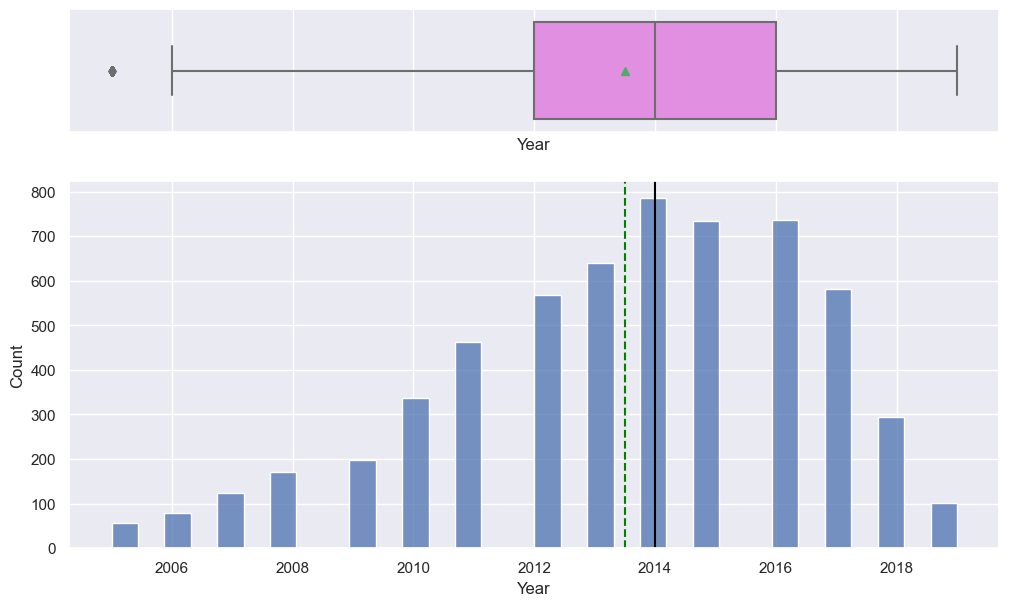

In [62]:
# Plot histogram and boxplot for year
histogram_boxplot(df3, "Year")

### Observation

- The year data is left skewed as would be expected due to normal vehicle obsolesence.  This is regarded as reliable data it is   very difficult to mistake the manufacturing year for a vehicle. 
- No standardization is to be applied.

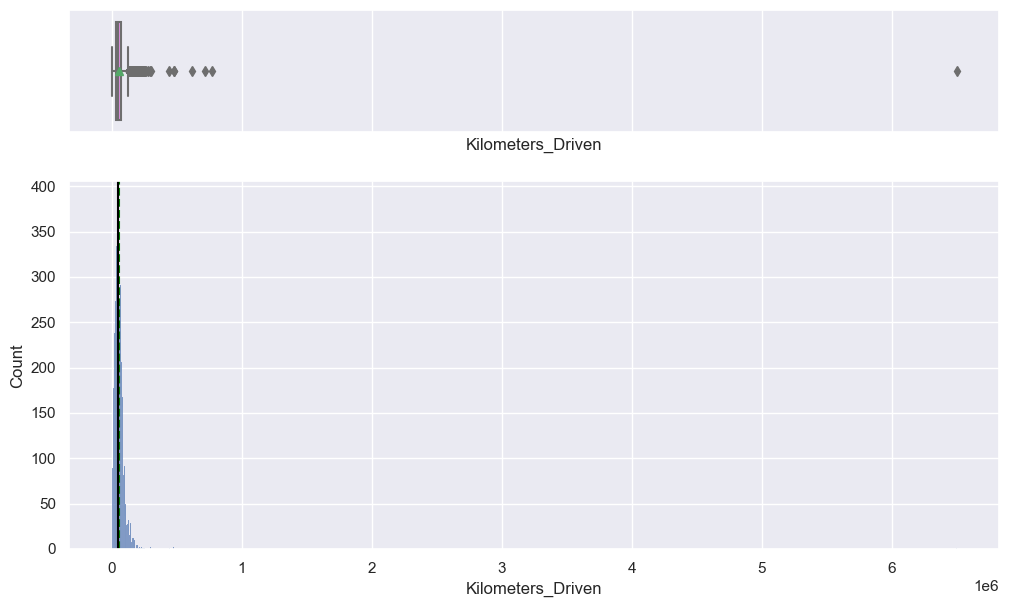

In [63]:
# Plot Kilometers_Driven
histogram_boxplot(df3, "Kilometers_Driven")

In [64]:
#Filter for Kilometers_Driven >= 400000
hi_km = df3.loc[(df3["Kilometers_Driven"] >= 400000)]
hi_km

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
340,Skoda Octavia Ambition Plus 2.0 TDI AT,Kolkata,2013,775000.0,Diesel,Automatic,First,19.30,1968.0,141.00,5.0,25.83,7.50,Skoda
358,Hyundai i10 Magna 1.2,Chennai,2009,620000.0,Petrol,Manual,First,20.36,1197.0,78.90,5.0,10.25,2.70,Hyundai
1860,Volkswagen Vento Diesel Highline,Chennai,2013,720000.0,Diesel,Manual,First,20.54,1598.0,103.60,5.0,13.23,5.90,Volkswagen
2328,BMW X5 xDrive 30d M Sport,Chennai,2017,6500000.0,Diesel,Automatic,First,15.97,2993.0,258.00,5.0,55.07,65.00,BMW
2823,Volkswagen Jetta 2013-2015 2.0L TDI Highline AT,Chennai,2015,480000.0,Diesel,Automatic,First,16.96,1968.0,138.03,5.0,10.15,13.00,Volkswagen
3092,Honda City i VTEC SV,Kolkata,2015,480000.0,Petrol,Manual,First,17.40,1497.0,117.30,5.0,13.58,5.00,Honda
4491,Hyundai i20 Magna Optional 1.2,Bangalore,2013,445000.0,Petrol,Manual,First,18.50,1197.0,82.90,5.0,10.25,4.45,Hyundai


### Observations

- Kilometers driven is a value which may not always be accurate. Odometers can malfunction. 
- Vehicle maximum lifetime in miles is normally 250000 which equates to 400000 km.  
- Will delete a small number of high side outliers with values >= 400000

In [65]:
#Clip Kilometers_Driven data >= 400000
df3.drop(df3.index[df3["Kilometers_Driven"] >= 400000], inplace=True)

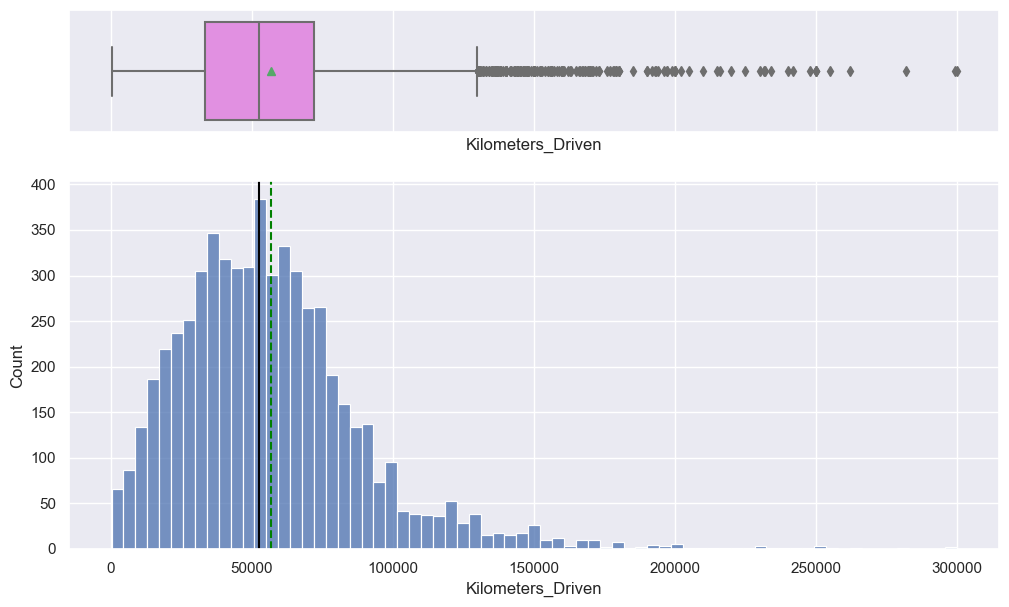

In [66]:
# Plot Kilometers_Driven variable
histogram_boxplot(df3, "Kilometers_Driven")

### Observations

- Kilometers driven data is right skewed.
- Kilometers_Driven variable will be standardized due to right skewed data.

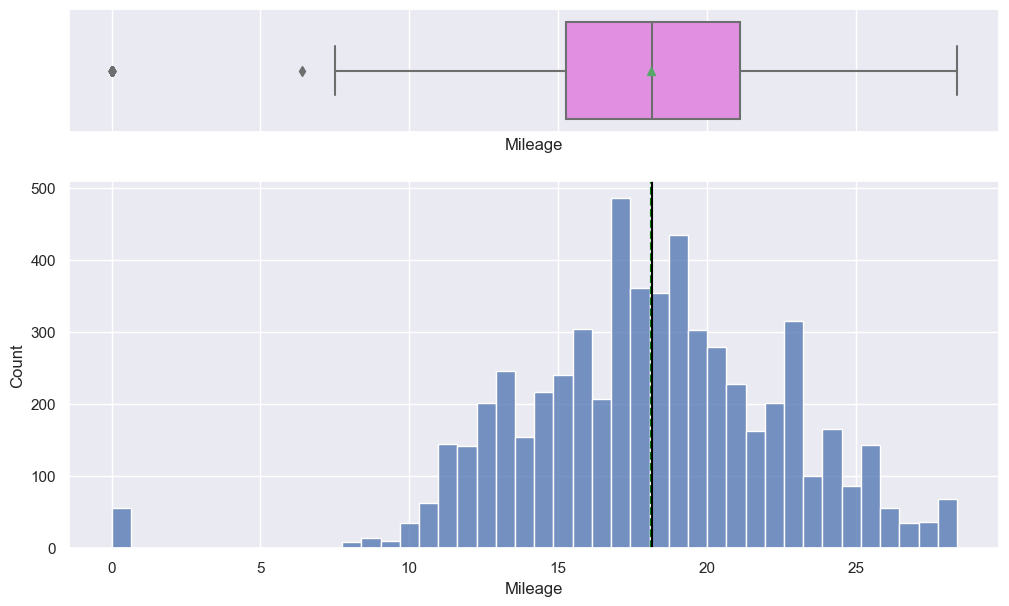

In [67]:
# Plot Mileage variable
histogram_boxplot(df3, "Mileage")

### Observations

- Mileage data has some low outliers that need to be clipped. Mileage left whisker value is 9.42

In [68]:
# Print data description
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,5863.0,2013.506055,3.032226,2005.00,2012.00,2014.00,2016.000,2019.0
Kilometers_Driven,5863.0,56605.896640,33412.415597,171.00,33467.50,52378.00,72016.000,300000.0
Mileage,5863.0,18.133263,4.450707,0.00,15.26,18.16,21.100,28.4
Engine,5863.0,1628.611632,599.798057,624.00,1198.00,1495.00,1991.000,5998.0
Power,5863.0,113.799376,53.401755,34.20,78.90,97.70,138.100,560.0
Seats,5863.0,5.279550,0.802676,0.00,5.00,5.00,5.000,10.0
New_Price,5863.0,21.691909,24.318685,3.91,8.07,11.30,23.250,375.0
Price,5863.0,9.646988,11.251846,0.44,3.55,5.75,10.195,160.0


In [69]:
# Filter dataframe for zero mileage
lo_mile = df3.loc[(df3["Mileage"] == 0)]
lo_mile

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
14,Land Rover Freelander 2 TD4 SE,Pune,2012,85000.0,Diesel,Automatic,Second,0.0,2179.0,115.00,5.0,120.000,17.50,Land
67,Mercedes-Benz C-Class Progressive C 220d,Coimbatore,2019,15369.0,Diesel,Automatic,First,0.0,1950.0,194.00,5.0,49.140,35.67,Mercedes-Benz
79,Hyundai Santro Xing XL,Hyderabad,2005,87591.0,Petrol,Manual,First,0.0,1086.0,97.70,5.0,4.550,1.30,Hyundai
194,Honda City 1.5 GXI,Ahmedabad,2007,60006.0,Petrol,Manual,First,0.0,1493.0,97.70,5.0,13.580,2.95,Honda
229,Ford Figo Diesel,Bangalore,2015,70436.0,Diesel,Manual,First,0.0,1498.0,99.00,5.0,7.650,3.60,Ford
262,Hyundai Santro Xing XL,Hyderabad,2006,99000.0,Petrol,Manual,First,0.0,1086.0,97.70,5.0,4.550,1.75,Hyundai
307,Hyundai Santro Xing XL,Chennai,2006,58000.0,Petrol,Manual,Second,0.0,1086.0,97.70,5.0,4.550,1.50,Hyundai
424,Volkswagen Jetta 2007-2011 1.9 L TDI,Hyderabad,2010,42021.0,Diesel,Manual,First,0.0,1968.0,97.70,5.0,10.150,5.45,Volkswagen
443,Hyundai Santro GLS I - Euro I,Coimbatore,2012,50243.0,Petrol,Manual,First,0.0,1086.0,97.70,5.0,4.550,3.35,Hyundai
544,Mercedes-Benz New C-Class Progressive C 200,Kochi,2019,13190.0,Petrol,Automatic,First,0.0,1950.0,181.43,5.0,49.490,38.99,Mercedes-Benz


In [70]:
# Examine median mileage for each brand
df3.groupby("Make")["Mileage"].median()

Make
Audi             15.730
BMW              17.050
Bentley           8.600
Chevrolet        18.200
Datsun           22.700
Fiat             19.000
Force            17.000
Ford             18.880
Honda            17.800
Hyundai          18.900
ISUZU            12.400
Isuzu            13.800
Jaguar           14.740
Jeep             17.100
Lamborghini       6.400
Land             12.630
Mahindra         15.100
Maruti           21.250
Mercedes-Benz    14.210
Mini             18.150
Mitsubishi       12.365
Nissan           19.340
Porsche          14.375
Renault          19.870
Skoda            17.200
Smart             0.000
Tata             20.300
Toyota           12.990
Volkswagen       17.210
Volvo            13.500
Name: Mileage, dtype: float64

In [71]:
# Delete Lamborghini from dataframe. Otherwise this will skew price and mileage data. New Price is 11.3   Price is 120.0 which
# is very inconsistent
df3.drop(df3.index[df3["Make"] == "Lamborghini"], inplace=True)

In [72]:
# Delete Bentley from dataframe. Otherwise this will skew price and mileage data. New Price is 375, several orders of
# magnitude greater than most cars.
df3.drop(df3.index[df3["Make"] == "Bentley"], inplace=True)

In [73]:
# Determine median mileage
mile_med = df3["Mileage"].median()
mile_med


18.16

In [74]:
# Set all zero mileage data to the median mileage data
df3["Mileage"].replace(0.0, 18.16, inplace=True)

Mileage data will be standardized

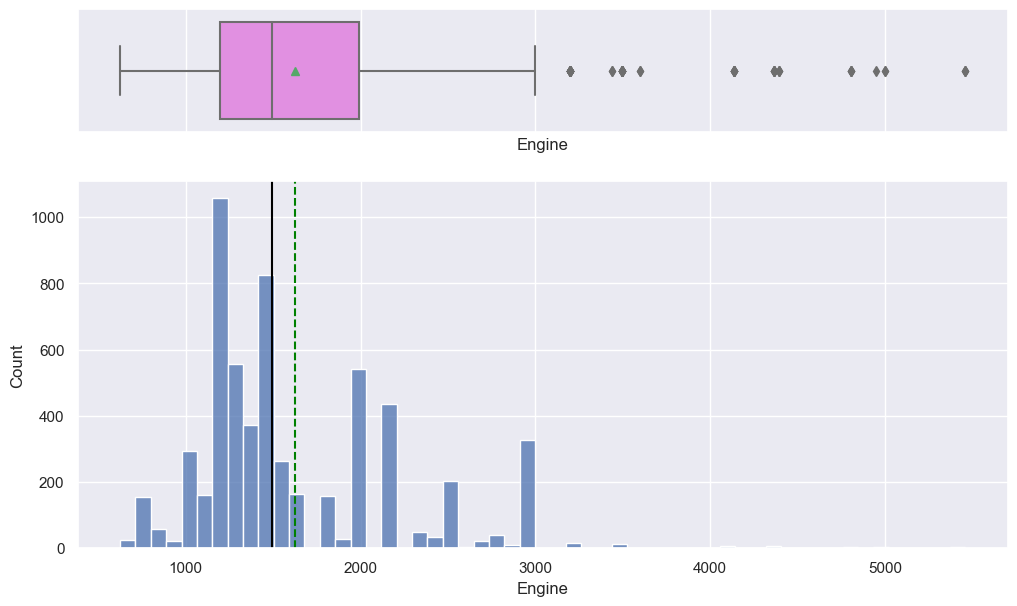

In [75]:
# Histogram and boxplot for engine data
histogram_boxplot(df3, "Engine")

In [76]:
# Filter for high engine displacement
high_engine = df3.loc[(df3["Engine"] >= 3000)]
high_engine

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
70,Porsche Cayenne 2009-2014 Turbo,Mumbai,2008,73000.0,Petrol,Automatic,First,8.50,4806.0,500.00,5.0,136.000,14.50,Porsche
152,Mercedes-Benz S Class 2005 2013 S 500,Kolkata,2010,35277.0,Petrol,Automatic,First,7.81,5461.0,362.90,5.0,49.490,30.00,Mercedes-Benz
459,Audi Q7 4.2 TDI Quattro Technology,Coimbatore,2016,51002.0,Diesel,Automatic,First,11.33,4134.0,335.20,7.0,101.960,48.91,Audi
586,Audi Q7 4.2 TDI Quattro Technology,Kochi,2014,79926.0,Diesel,Automatic,First,11.33,4134.0,335.20,7.0,101.960,29.77,Audi
589,Mercedes-Benz S Class 2005 2013 S 350 L,Bangalore,2006,47088.0,Petrol,Automatic,Second,10.13,3498.0,364.90,5.0,49.490,19.00,Mercedes-Benz
693,Mercedes-Benz SLK-Class SLK 350,Coimbatore,2016,22732.0,Petrol,Automatic,First,18.10,3498.0,306.00,2.0,49.490,55.54,Mercedes-Benz
703,Ford Endeavour 3.2 Trend AT 4X4,Coimbatore,2017,50484.0,Diesel,Automatic,First,10.91,3198.0,197.20,7.0,35.290,31.12,Ford
798,Mercedes-Benz SLK-Class SLK 350,Bangalore,2015,10000.0,Petrol,Automatic,First,18.10,3498.0,306.00,2.0,49.490,55.00,Mercedes-Benz
806,Ford Endeavour 3.2 Titanium AT 4X4,Coimbatore,2017,59636.0,Diesel,Automatic,First,10.91,3198.0,197.00,7.0,35.290,29.20,Ford
926,Porsche Cayman 2009-2012 S,Hyderabad,2010,10000.0,Petrol,Manual,First,9.00,3436.0,97.70,2.0,136.000,40.00,Porsche


### Observations

- The high engine displacement data appears to be valid.  It is comprised primarily of high powered expensive vehicle imported
  into India. This appears to be valid data and any right skew will be dealt with by standardization. 

- Any data trimmed as high outliers for power may tend to be colinear with high engine displacement and may impact this data as
  well. Power is a more valid parameter to use for trimming as more costly technology such as turbocharging can enable an
  engine to deliver a disproportionately high power level.

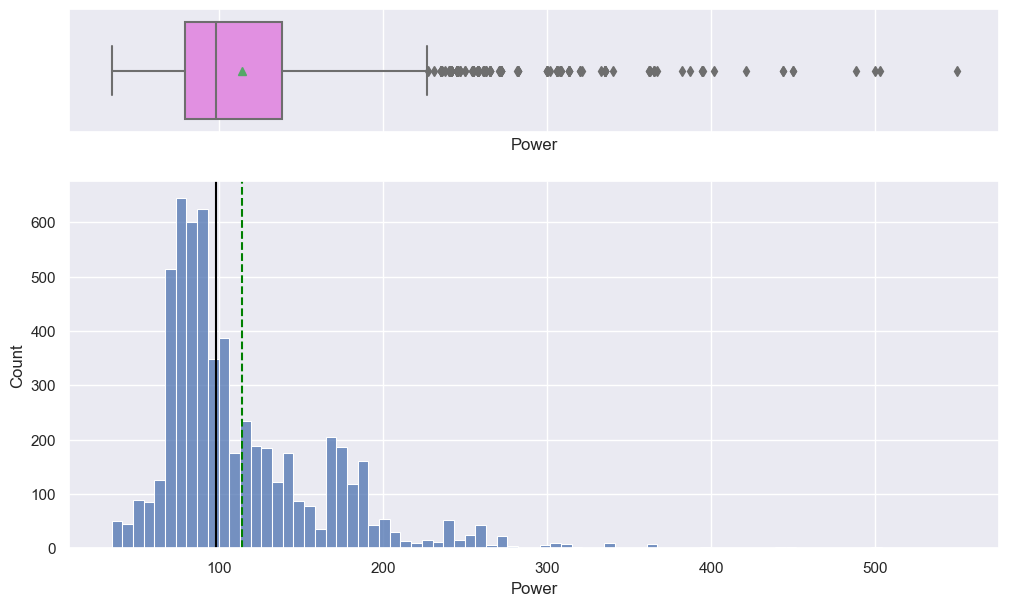

In [77]:
# Histogram and boxplot for power data
histogram_boxplot(df3, "Power")

In [78]:
# Check descriptive statistics
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,5861.0,2013.507763,3.030980,2005.00,2012.00,2014.00,2016.00,2019.0
Kilometers_Driven,5861.0,56615.914008,33411.515490,171.00,33485.00,52380.00,72022.00,300000.0
Mileage,5861.0,18.310404,4.074667,7.50,15.40,18.16,21.10,28.4
Engine,5861.0,1627.256100,595.348001,624.00,1198.00,1495.00,1991.00,5461.0
Power,5861.0,113.648480,52.782145,34.20,78.90,97.70,138.10,550.0
Seats,5861.0,5.280328,0.801494,0.00,5.00,5.00,5.00,10.0
New_Price,5861.0,21.633400,23.880472,3.91,8.05,11.30,23.25,230.0
Price,5861.0,9.619739,11.142384,0.44,3.55,5.75,10.17,160.0


### Observations

- The power data is right skewed. The right whisker value is 226.9
- The vehicles with power >= 250 are imported large engine displacement luxury vehicles.
- Per the website India-Briefing.com 18.6 million vehicles were sold in India in 2021, however, per the website
  less than 20,000 luxury vehicles were sold.  
- Vehicles with power greater than 250 will be trimmed from the data frame. Standardization will also be applied for this
  variable.

In [79]:
# Filter for high power
high_power = df3.loc[(df3["Power"] >= 250)]
high_power

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
38,Mercedes-Benz M-Class ML 350 CDI,Pune,2013,85000.0,Diesel,Automatic,First,11.74,2987.0,254.80,5.0,49.490,28.00,Mercedes-Benz
70,Porsche Cayenne 2009-2014 Turbo,Mumbai,2008,73000.0,Petrol,Automatic,First,8.50,4806.0,500.00,5.0,136.000,14.50,Porsche
107,Jaguar XF 3.0 Litre S Premium Luxury,Hyderabad,2011,78000.0,Diesel,Automatic,Second,14.74,2993.0,270.90,5.0,69.675,24.00,Jaguar
134,Mercedes-Benz SLC 43 AMG,Kolkata,2017,13372.0,Petrol,Automatic,First,19.00,2996.0,362.07,2.0,95.040,54.00,Mercedes-Benz
148,Audi RS5 Coupe,Mumbai,2013,23000.0,Petrol,Automatic,First,11.05,2894.0,444.00,4.0,128.000,37.00,Audi
152,Mercedes-Benz S Class 2005 2013 S 500,Kolkata,2010,35277.0,Petrol,Automatic,First,7.81,5461.0,362.90,5.0,49.490,30.00,Mercedes-Benz
168,BMW X5 xDrive 30d,Mumbai,2015,41000.0,Diesel,Automatic,First,15.30,2993.0,258.00,5.0,55.070,45.00,BMW
264,Mercedes-Benz GLE 350d,Coimbatore,2017,29819.0,Diesel,Automatic,First,11.57,2987.0,254.79,5.0,95.130,61.29,Mercedes-Benz
271,BMW X3 xDrive30d M Sport,Coimbatore,2017,51982.0,Diesel,Automatic,First,16.55,2993.0,258.00,5.0,69.590,45.77,BMW
326,BMW 6 Series 640d Gran Coupe,Mumbai,2011,30000.0,Diesel,Automatic,First,9.52,2993.0,313.00,4.0,55.070,49.00,BMW


In [80]:
# Trim data with power greater than or equal to 250
df3.drop(df3.index[df3["Power"] >= 250], inplace=True)

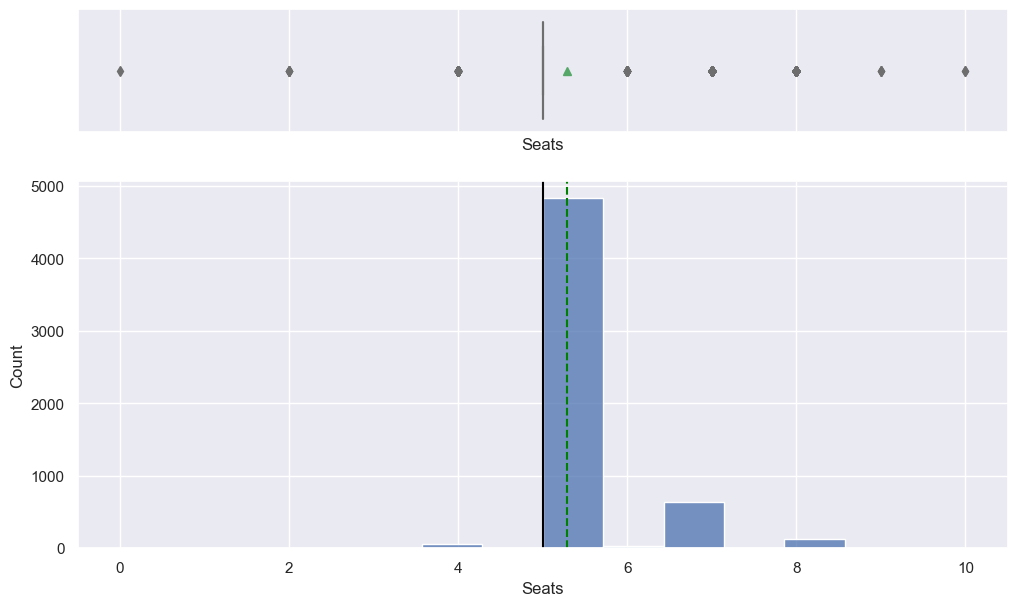

In [81]:
# Histogram and boxplot for seats
histogram_boxplot(df3, "Seats")

In [82]:
# For Seats 25th and 75th percentile are 5 (identical), so IQR is zero. Investigate low values and high values for seats.
high_seats = df3.loc[(df3["Seats"] >= 9)]
high_seats

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
917,Tata Sumo DX,Mumbai,2013,20000.0,Diesel,Manual,First,14.07,1978.0,83.1,10.0,7.630,5.25,Tata
1347,Mahindra Scorpio LX BS IV,Bangalore,2007,74112.0,Diesel,Manual,First,12.05,2179.0,120.0,9.0,18.865,4.10,Mahindra
2312,Chevrolet Tavera LT 9 Str BS IV,Kolkata,2012,67132.0,Diesel,Manual,First,13.58,2499.0,78.0,9.0,11.300,4.75,Chevrolet
2359,Mahindra Xylo D2 Maxx,Chennai,2016,150000.0,Diesel,Manual,First,14.95,2489.0,93.7,9.0,11.670,4.50,Mahindra
2575,Chevrolet Tavera LS B3 10 Seats BSIII,Hyderabad,2015,120000.0,Diesel,Manual,First,14.80,2499.0,80.0,10.0,11.300,5.50,Chevrolet


In [83]:
# Filter data for seats <= 3
low_seats = df3.loc[(df3["Seats"] <= 3)]
low_seats

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
557,Audi TT 2.0 TFSI,Delhi,2013,12100.0,Petrol,Automatic,First,9.90,1984.0,207.8,2.0,53.14,29.50,Audi
915,Smart Fortwo CDI AT,Pune,2008,103000.0,Diesel,Automatic,Second,18.16,799.0,97.7,2.0,11.30,3.00,Smart
926,Porsche Cayman 2009-2012 S,Hyderabad,2010,10000.0,Petrol,Manual,First,9.00,3436.0,97.7,2.0,136.00,40.00,Porsche
1288,Audi TT 2.0 TFSI,Kochi,2014,14262.0,Petrol,Automatic,First,9.90,1984.0,207.8,2.0,53.14,27.35,Audi
2305,Porsche Cayman 2009-2012 S tiptronic,Mumbai,2011,8000.0,Petrol,Automatic,First,9.00,3436.0,97.7,2.0,136.00,43.00,Porsche
3999,Audi A4 3.2 FSI Tiptronic Quattro,Hyderabad,2012,125000.0,Petrol,Automatic,First,10.50,3197.0,97.7,0.0,53.14,18.00,Audi


In [84]:
# Set zero seat data to the median seat data
df3["Seats"].replace(0.0, 5.0, inplace=True)

In [85]:
# Save a dataframe which will later be used for exploring categorical variables.
df_cat = df3.copy()

In [86]:
# Seat data appears to be reasonable
df3.groupby("Make")["Seats"].median()

Make
Audi             5.0
BMW              5.0
Chevrolet        5.0
Datsun           5.0
Fiat             5.0
Force            7.0
Ford             5.0
Honda            5.0
Hyundai          5.0
ISUZU            5.0
Isuzu            7.0
Jaguar           5.0
Jeep             5.0
Land             5.0
Mahindra         7.0
Maruti           5.0
Mercedes-Benz    5.0
Mini             4.0
Mitsubishi       6.0
Nissan           5.0
Porsche          5.0
Renault          5.0
Skoda            5.0
Smart            2.0
Tata             5.0
Toyota           7.0
Volkswagen       5.0
Volvo            5.0
Name: Seats, dtype: float64

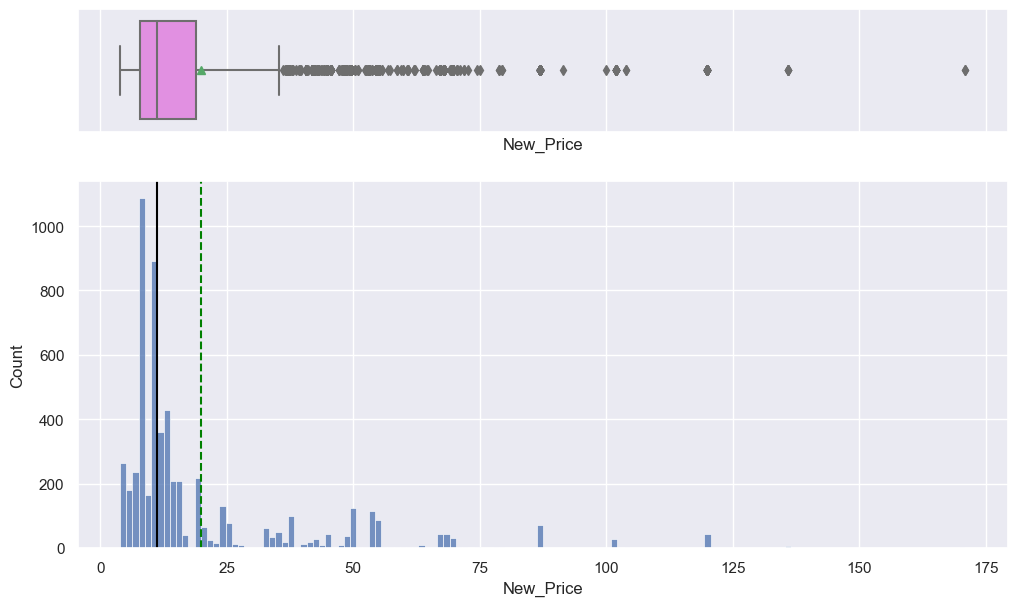

In [87]:
# Histogram and boxplot for new price
histogram_boxplot(df3, "New_Price")

###  Observations

- Right whisker value is 46.05.  Left whisker value is minimum new cost of 3.91


In [88]:
# Filter to investigate high outlier values
high_newprice = df3.loc[(df3["New_Price"] >= 55)]
high_newprice

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
13,Land Rover Range Rover 2.2L Pure,Delhi,2014,72000.0,Diesel,Automatic,First,12.70,2179.0,187.70,5.0,120.000,27.00,Land
14,Land Rover Freelander 2 TD4 SE,Pune,2012,85000.0,Diesel,Automatic,Second,18.16,2179.0,115.00,5.0,120.000,17.50,Land
22,Audi A6 2011-2015 35 TFSI Technology,Mumbai,2015,55985.0,Petrol,Automatic,First,13.53,1984.0,177.01,5.0,67.100,23.50,Audi
33,Audi A6 2.7 TDI,Kolkata,2010,35000.0,Diesel,Automatic,First,12.40,2698.0,179.50,5.0,67.100,11.50,Audi
75,Audi A6 2.0 TDI Design Edition,Delhi,2014,56000.0,Diesel,Automatic,Second,18.53,1968.0,187.74,5.0,67.100,29.50,Audi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,Mercedes-Benz E-Class 200 Kompressor Elegance,Delhi,2014,40000.0,Petrol,Automatic,First,10.50,1796.0,157.70,5.0,86.970,24.00,Mercedes-Benz
5900,Mercedes-Benz GLC 220,Coimbatore,2017,50794.0,Diesel,Automatic,First,17.90,2143.0,170.00,5.0,63.805,43.30,Mercedes-Benz
5921,Mercedes-Benz E-Class 2015-2017 E250 CDI Avant...,Mumbai,2016,21000.0,Diesel,Automatic,First,13.00,2143.0,204.00,5.0,86.970,36.00,Mercedes-Benz
5996,Jaguar XF 2.2 Litre Luxury,Kochi,2016,31150.0,Diesel,Automatic,First,16.36,2179.0,187.70,5.0,69.675,30.54,Jaguar


In [89]:
# Determine vehicle median new prices
df3.groupby("Make")["New_Price"].median()

Make
Audi              53.140
BMW               54.430
Chevrolet         11.300
Datsun             5.635
Fiat               9.075
Force             11.300
Ford              11.685
Honda             13.580
Hyundai           10.250
ISUZU             33.680
Isuzu             33.680
Jaguar            69.675
Jeep              23.190
Land             120.000
Mahindra          18.865
Maruti             7.880
Mercedes-Benz     49.490
Mini              42.120
Mitsubishi        33.210
Nissan            11.330
Porsche          136.000
Renault           15.050
Skoda             25.830
Smart             11.300
Tata               7.630
Toyota            24.010
Volkswagen        10.150
Volvo             45.670
Name: New_Price, dtype: float64

In [90]:
# Trim vehicles with a new price greater than 55 from the dataframe. 
# This is much less than the average new price of the Land Rover, Porsche, and Jaguar.  
# These models are sold in very small numbers and there is a concern wih these data points negatively impacting model precision 
# for predicting prices of automobiles sold in large numbers.

# Trim data with new price greater than or equal to 50000
df3.drop(df3.index[df3["New_Price"] >= 55], inplace=True)

In [91]:
# Recheck vehicle median new prices
df3.groupby("Make")["New_Price"].median()

Make
Audi             53.140
BMW              54.430
Chevrolet        11.300
Datsun            5.635
Fiat              9.075
Force            11.300
Ford             11.685
Honda            13.580
Hyundai          10.250
ISUZU            33.680
Isuzu            33.680
Jaguar           53.410
Jeep             23.190
Mahindra         18.865
Maruti            7.880
Mercedes-Benz    49.490
Mini             42.120
Mitsubishi       33.210
Nissan           11.330
Renault          15.050
Skoda            25.830
Smart            11.300
Tata              7.630
Toyota           24.010
Volkswagen       10.150
Volvo            45.670
Name: New_Price, dtype: float64

###  Multivariate Analysis

<Axes: >

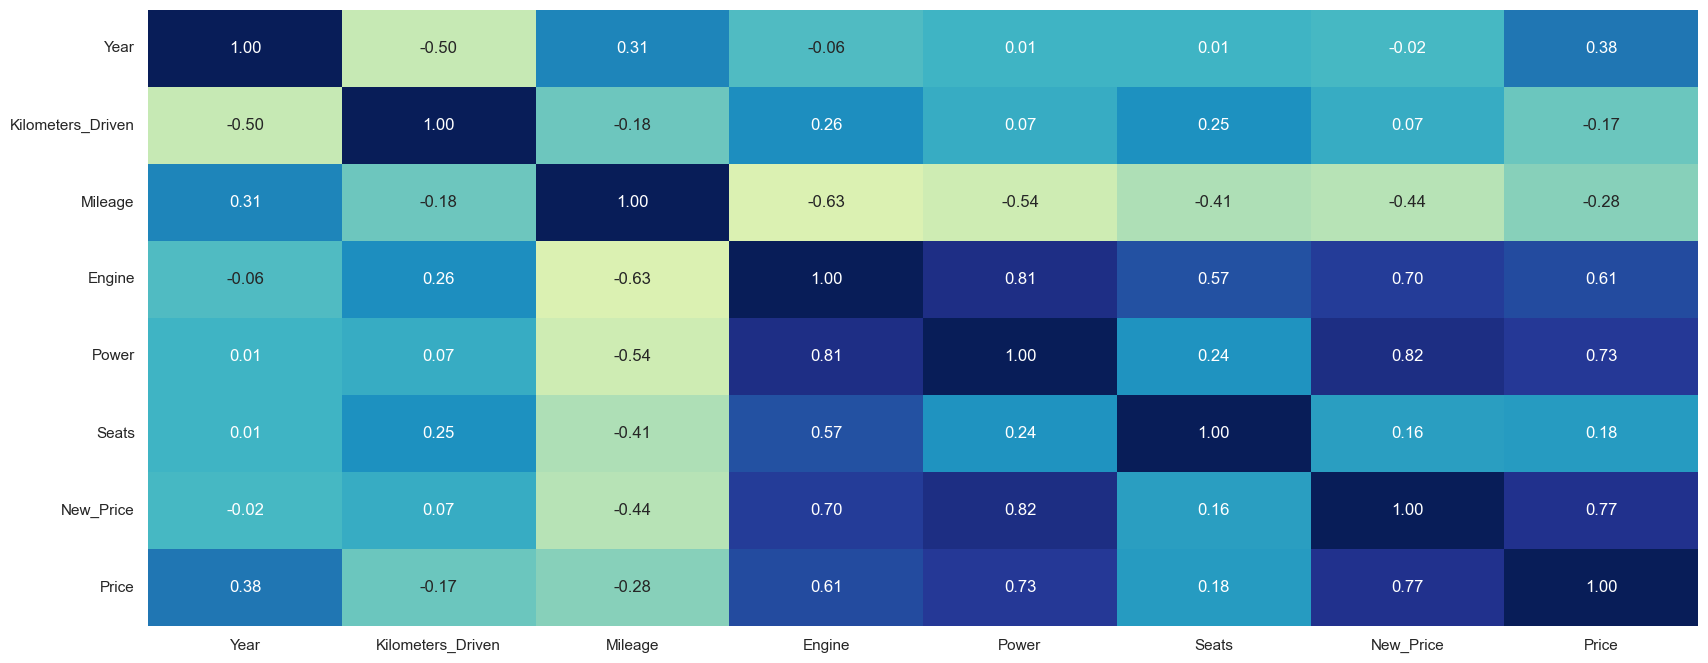

In [92]:
#Create a 8 x 8 correlation matrix and check for correlation among numerical values
num_var = ['Year','Kilometers_Driven','Mileage','Engine','Power', 'Seats', 'New_Price', 'Price']

corr = df3[num_var].corr()

# Plot the heatmap

plt.figure(figsize=(20, 8))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="YlGnBu", cbar=False)


### Observations

- Power and Engine are positively correlated.  
- Price is positively correlated with Power, Engine and New_Price. 
- Price has weak positive correlation with year and very weak negative correlation with Mileage and Kilometers_Driven.

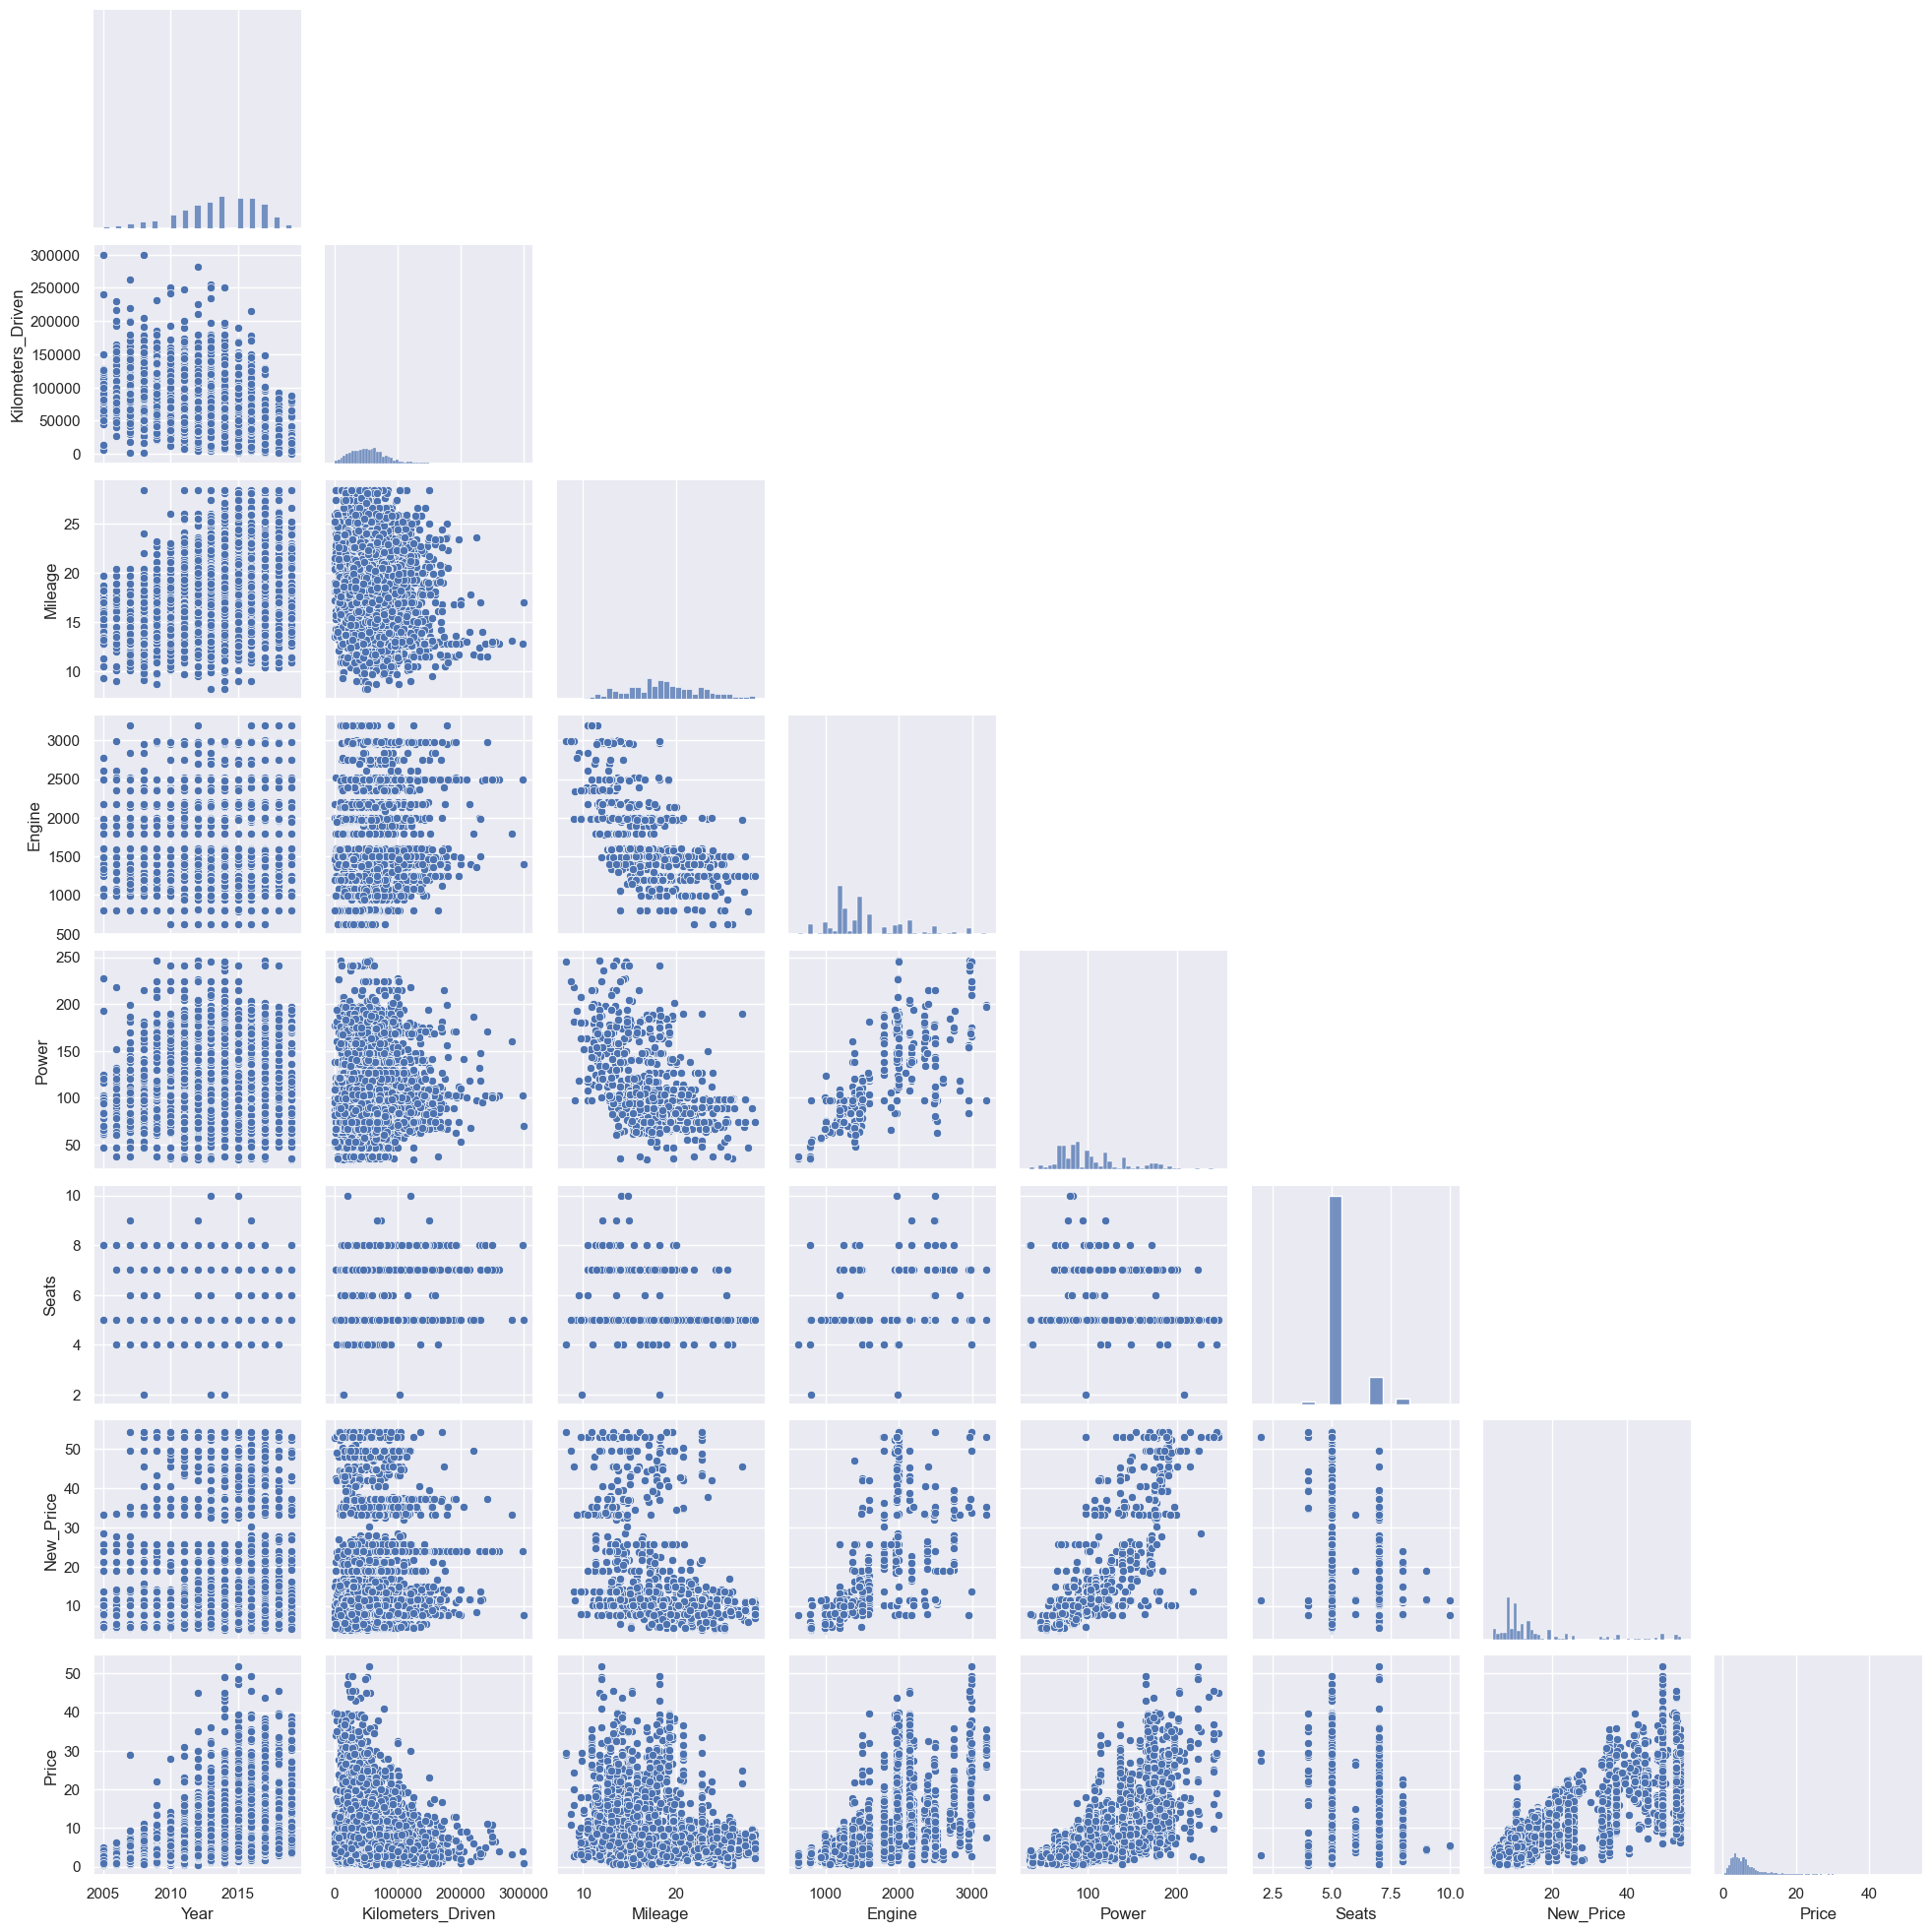

In [93]:
#Present pairplot of overall dataset numerical values
sns.pairplot(data=df3[num_var], kind="scatter", corner=True)

### Observations

- Power and Engine are positively correlated.  
- Price is positively correlated with Power, Engine and New_Price. 
- Price has wek positive correlation with year and very weak negative correlation with Mileage and Kilometers_Driven.

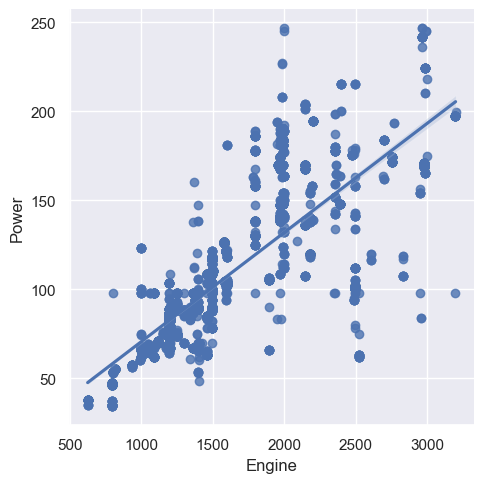

In [94]:
# Investigate relationship between power and Engine
sns.lmplot(data=df3, x="Engine", y="Power")

### Observations

- There is a positive correlation between engine displacement and power. 
- Regression will be performed with both variables in the data and an alternate analysis with engine removed from the analysis.

### Categorize vehicles as either domestic, imports, or luxury

- Explore categorical variables using a dataframe saved previously. 
- For informational purposes, this dataframe will still contain data on some very high end vehicles that were trimmed from the
  regression analysis for predicting used car prices

In [95]:
df_cat["Make"] = df_cat["Make"].replace(
    {
        "Chevrolet": "Import",
        "Datsun": "Import",
        "Fiat": "Import",
        "Ford": "Import",
        "Honda": "Import",
        "Hyundai": "Import",
        "ISUZU": "Import",
        "Isuzu": "Import",
        "Jeep": "Import",
        "Mitsubishi": "Import",
        "Nissan": "Import",
        "Renault": "Import",
        "Skoda": "Import",
        "Mini": "Import",
        "Smart": "Import",
        "Toyota": "Import",
        "Volkswagen": "Import",
    }
)

In [96]:
df_cat["Make"] = df_cat["Make"].replace(
    {
        "Audi": "Luxury",
        "BMW": "Luxury",
        "Jaguar": "Luxury",
        "Land": "Luxury",
        "Mercedes-Benz": "Luxury",
        "Porsche": "Luxury",
        "Volvo": "Luxury",
    }
)

In [97]:
df_cat["Make"] = df_cat["Make"].replace(
    {
        "Ambassador": "Domestic",
        "Force": "Domestic",
        "Mahindra": "Domestic",
        "Maruti": "Domestic",
        "Tata": "Domestic",
    }
)

In [98]:
#Check dataframe head
df_cat.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Make
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000.0,Diesel,Manual,First,19.67,1582.0,126.20,5.0,16.06,12.50,Import
2,Honda Jazz V,Chennai,2011,46000.0,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61,4.50,Import
3,Maruti Ertiga VDI,Chennai,2012,87000.0,Diesel,Manual,First,20.77,1248.0,88.76,7.0,11.27,6.00,Domestic
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670.0,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,53.14,17.74,Luxury
6,Nissan Micra Diesel XV,Jaipur,2013,86999.0,Diesel,Manual,First,23.08,1461.0,63.10,5.0,9.47,3.50,Import


In [99]:
# Calculate Make value counts
print(df_cat["Make"].value_counts().sort_index(ascending=True))

Domestic    1580
Import      3325
Luxury       799
Name: Make, dtype: int64


<Axes: xlabel='Make', ylabel='count'>

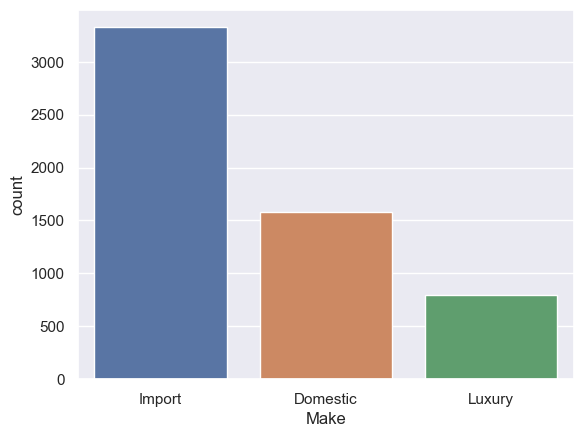

In [100]:
#Countplot for categories of vehicles
sns.countplot(data=df_cat, x="Make")

### Observations

- Imported vehicles are the largest volume market segment

In [101]:
#Investigate prices of various types of vehicles
df_cat.groupby("Make")["Price"].median()

Make
Domestic     4.50
Import       5.21
Luxury      22.45
Name: Price, dtype: float64

### Observations

- Luxury cars have by far the highest average price

In [102]:
#Calculate total sales value of different vehicles classes
df_cat.groupby("Make")["Price"].sum()

Make
Domestic     8110.85
Import      21893.65
Luxury      19367.13
Name: Price, dtype: float64

### Observations

The total value of import sales is largest because of greater sales volume.  

In [103]:
#Calculate Owner_Type value counts
print(df_cat["Owner_Type"].value_counts().sort_index(ascending=True))

First             4707
Fourth & Above       8
Second             899
Third               90
Name: Owner_Type, dtype: int64


<Axes: xlabel='Owner_Type', ylabel='count'>

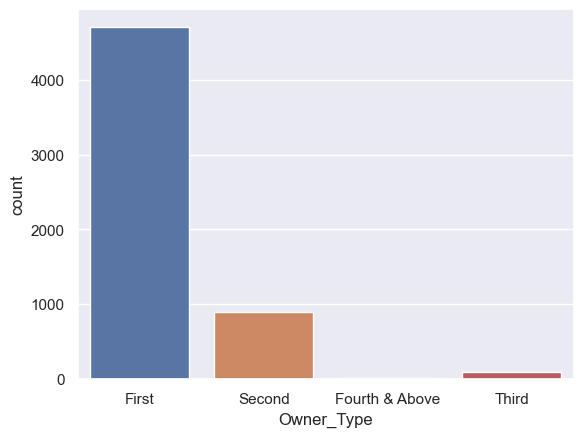

In [104]:
#Countplot of Owner_Types
sns.countplot(data=df_cat, x="Owner_Type")

<Axes: xlabel='Owner_Type', ylabel='count'>

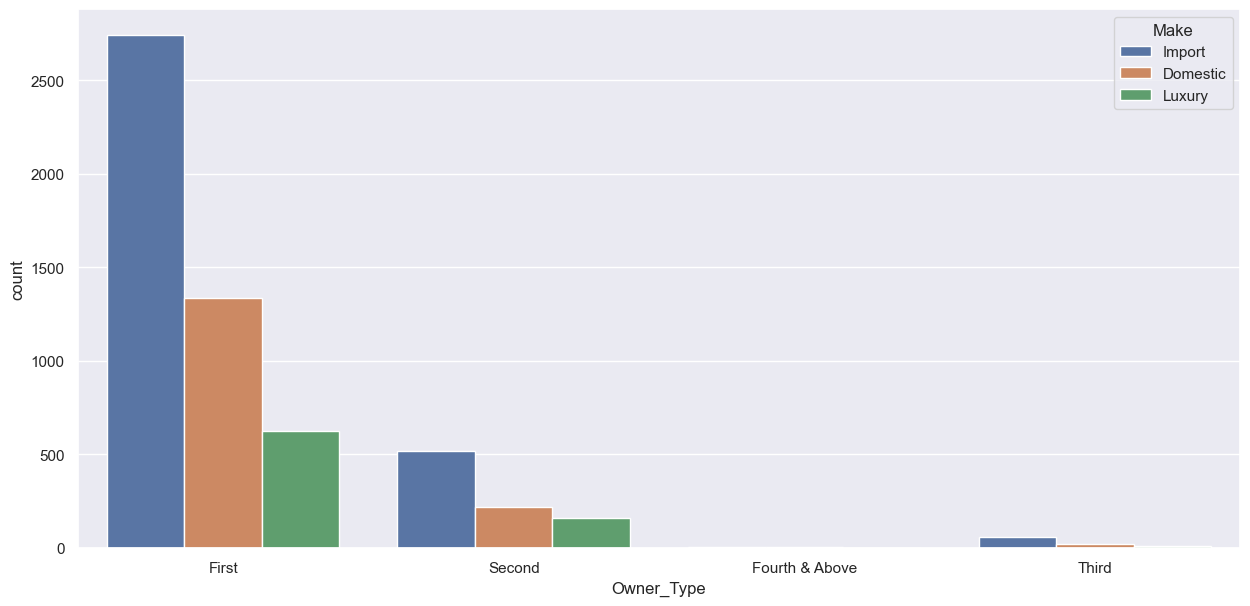

In [105]:
#Countplot of Owner_Types with Make as hue
plt.figure(figsize=(15, 7))
sns.countplot(data=df_cat, x="Owner_Type", hue="Make")

<Axes: xlabel='Location', ylabel='count'>

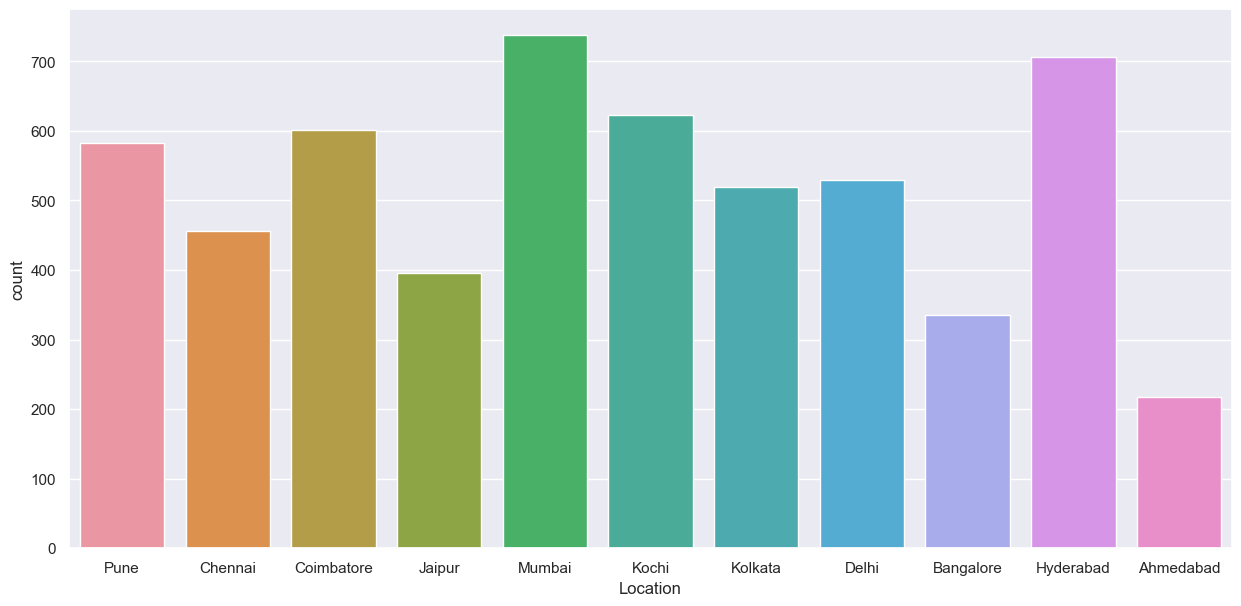

In [106]:
# Location countplot
plt.figure(figsize=(15, 7))
sns.countplot(data=df_cat, x="Location")

### Observations

- The largest volume market is Mumbai followed by Hyderabad

In [107]:
#Make a copy of dataframe
df4 = df3.copy()

### Observations 

- Standardization/Normalization and Log Transformation for continuous variables
- Year - No further data conditioning to be applied other than data trimming to remove obsolescent units (not functioning)
- Kilometers_Driven - This data is right skewed and a log transformation will be applied
- Engine - This data is right skewed and log ransformation will be applied
- Power - This data is right skewed and log transformation will be applied
- Mileage - This data has a normal distribution but is considered relatively imprecise. A standard scaler will be applied
- Seats - No further data conditioning to be applied. Data to heavily weighted to the median value of 5 seats
- New_Price - Data trimming completed. No further data conditioning to be applied as this data is only slightly right skewed

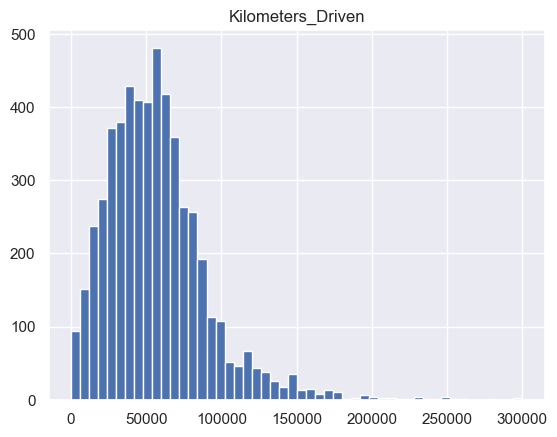

0


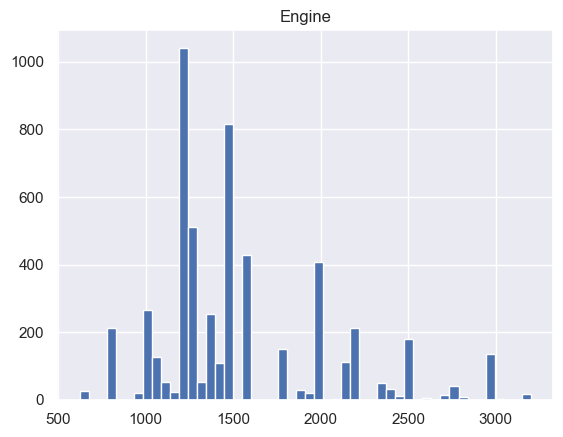

0


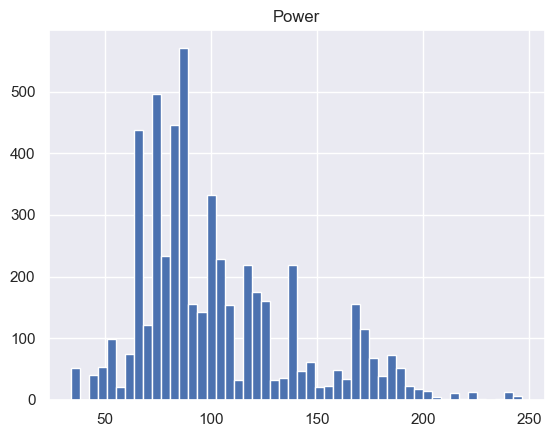

0


In [108]:
# Check for negative values prior to log transformations 
cols_to_log = ["Kilometers_Driven", "Engine", "Power"]
for colname in cols_to_log:
    plt.hist(df4[colname], bins=50)
    plt.title(colname)
    plt.show()
    print(np.sum(df4[colname] <= 0))

In [109]:
#Implement Log transform
for colname in cols_to_log:
    df4[colname + "_log"] = np.log(df4[colname])
df4.drop(cols_to_log, axis=1, inplace=True)

In [110]:
#Check dataframe head
df4.head()

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Mileage,Seats,New_Price,Price,Make,Kilometers_Driven_log,Engine_log,Power_log
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,Diesel,Manual,First,19.67,5.0,16.06,12.50,Hyundai,10.621327,7.366445,4.837868
2,Honda Jazz V,Chennai,2011,Petrol,Manual,First,18.20,5.0,8.61,4.50,Honda,10.736397,7.089243,4.485260
3,Maruti Ertiga VDI,Chennai,2012,Diesel,Manual,First,20.77,7.0,11.27,6.00,Maruti,11.373663,7.129298,4.485936
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,Diesel,Automatic,Second,15.20,5.0,53.14,17.74,Audi,10.613246,7.584773,4.947340
6,Nissan Micra Diesel XV,Jaipur,2013,Diesel,Manual,First,23.08,5.0,9.47,3.50,Nissan,11.373652,7.286876,4.144721


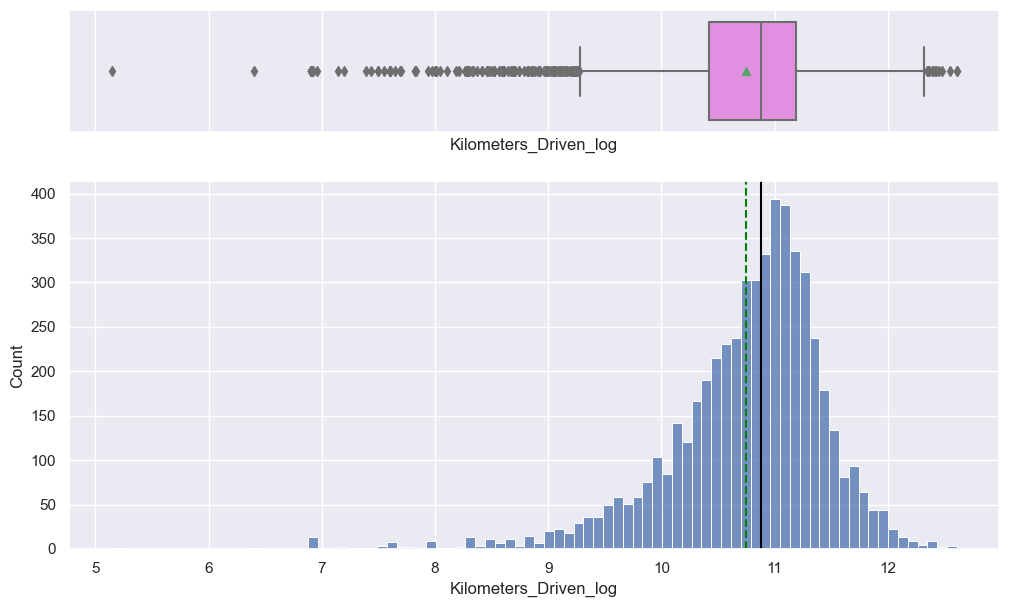

In [111]:
#Histogram and boxplot of Kilometers_Drive_log
histogram_boxplot(df4, "Kilometers_Driven_log")

### Observations

- Data is still slightly left skewed

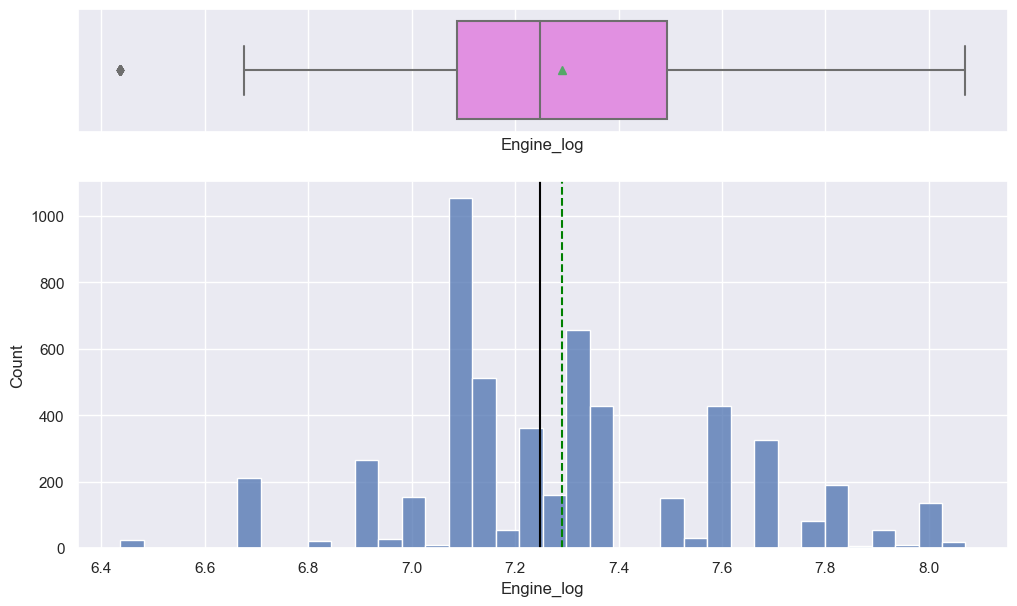

In [112]:
#Histogram and boxplot of Engine_log
histogram_boxplot(df4, "Engine_log")

### Observations

Data appears to be more normally distributed

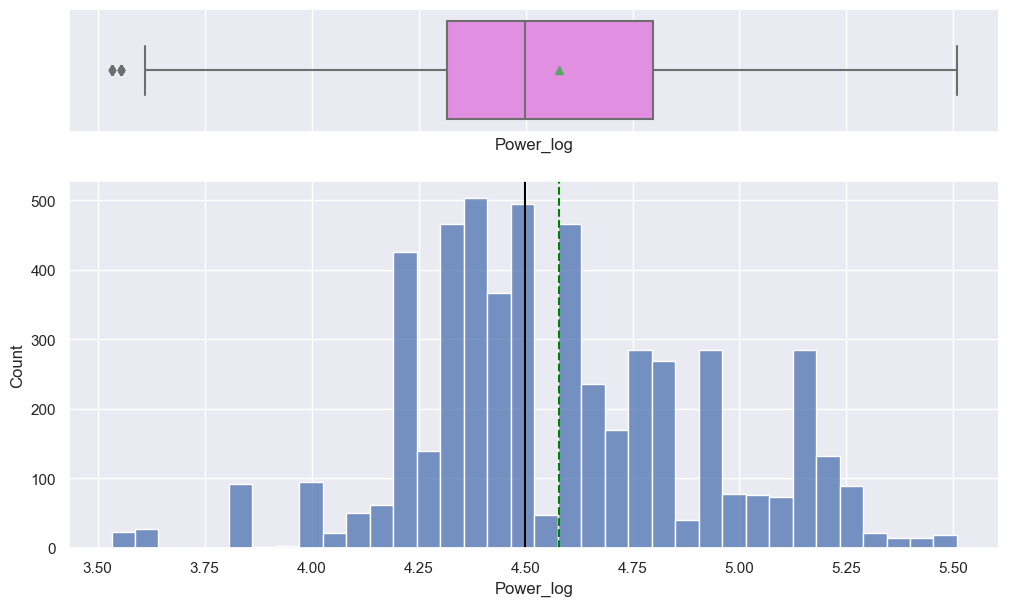

In [113]:
#Histogram and boxplot of Power_log
histogram_boxplot(df4, "Power_log")

### Observations 

- Data still appears to be distributed in disparate ranges

In [114]:
# Import Sclaer libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler

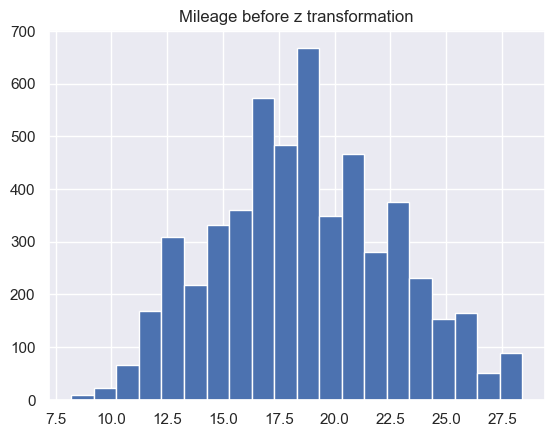

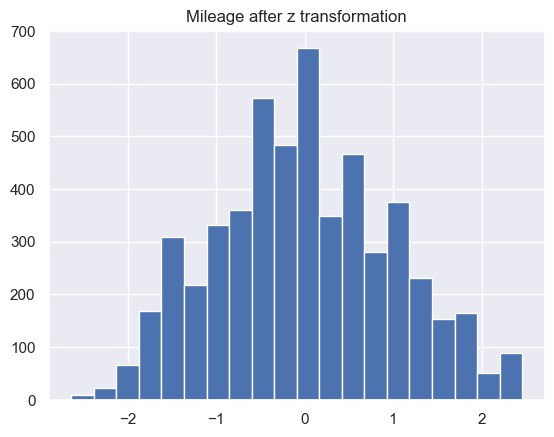

In [115]:
#Implement standard scaler
std_scaler = StandardScaler()

df4["Mileage"].hist(bins=20)
plt.title("Mileage before z transformation")
plt.show()
# fit_transform requires a DataFrame, not a Series, hence
# the double brackets to keep df[["Mileage"]] as a 1 column
# DataFrame rather than a Series, like done with df4["Mileage"]


df4["Mileage_z_std"] = std_scaler.fit_transform(df4[["Mileage"]])
df4["Mileage_z_std"].hist(bins=20)
plt.title("Mileage after z transformation")
plt.show()

df4.drop(["Mileage"], axis=1, inplace=True)

### Observations

- Mileage is in exact same shape since it is a linear transformation


In [116]:
#Make a dataframe copy
df5 = df4.copy()

In [117]:
# Remove name column
df5.drop("Name", axis=1, inplace=True)

Process non-numeric data with get_dummies 

In [118]:
# Drop first variable to reduce number of parameters
df5 = pd.get_dummies(
    df5,
    columns=["Location", "Fuel_Type", "Transmission", "Owner_Type", "Make"],
    drop_first=True,
)

In [119]:
#Check dataframe head
df5.head()

,Year,Seats,New_Price,Price,Kilometers_Driven_log,Engine_log,Power_log,Mileage_z_std,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Make_BMW,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Force,Make_Ford,Make_Honda,Make_Hyundai,Make_ISUZU,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini,Make_Mitsubishi,Make_Nissan,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo
1,2015,5.0,16.06,12.50,10.621327,7.366445,4.837868,0.256954,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2011,5.0,8.61,4.50,10.736397,7.089243,4.485260,-0.113848,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2012,7.0,11.27,6.00,11.373663,7.129298,4.485936,0.534425,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013,5.0,53.14,17.74,10.613246,7.584773,4.947340,-0.870587,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2013,5.0,9.47,3.50,11.373652,7.286876,4.144721,1.117115,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [120]:
# Make a copy of dataframe for alternative model evaluation
df6 = df5.copy()

## Build Linear Regression Models

In [121]:
# independant variables
x = df5.drop(["Price"], axis=1)
# the dependent variable
y = df5[["Price"]]

In [122]:
# Split x and y into training and test set in 70:30 ratio

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=1
)

### Check fidelity of train and test data before proceeding

In [123]:
# Descriptive statistics for training data
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,3758.0,2013.486163,3.059206,2005.000000,2012.000000,2014.000000,2016.000000,2019.000000
Seats,3758.0,5.286589,0.778734,2.000000,5.000000,5.000000,5.000000,10.000000
New_Price,3758.0,15.898244,12.580873,3.910000,7.880000,11.110000,16.650000,54.430000
Kilometers_Driven_log,3758.0,10.754159,0.704392,5.141664,10.434116,10.878047,11.198215,12.609275
Engine_log,3758.0,7.289594,0.300339,6.436150,7.087574,7.247793,7.494430,8.070906
Power_log,3758.0,4.578260,0.346349,3.532226,4.304065,4.499810,4.798267,5.508335
Mileage_z_std,3758.0,0.007852,1.000278,-2.636311,-0.668790,-0.012949,0.692079,2.459065
Location_Bangalore,3758.0,0.058010,0.233793,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Chennai,3758.0,0.079031,0.269824,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Coimbatore,3758.0,0.105109,0.306735,0.000000,0.000000,0.000000,0.000000,1.000000


In [124]:
# Descriptive statistics for testing data
x_test.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Year,1611.0,2013.549348,2.977225,2005.000000,2012.000000,2014.000000,2016.000000,2019.000000
Seats,1611.0,5.313470,0.812441,2.000000,5.000000,5.000000,5.000000,10.000000
New_Price,1611.0,15.899494,12.687825,3.910000,7.880000,11.010000,16.060000,54.700000
Kilometers_Driven_log,1611.0,10.741705,0.737716,6.396930,10.404263,10.884104,11.184421,12.611538
Engine_log,1611.0,7.290864,0.309147,6.436150,7.087574,7.247793,7.494430,8.070281
Power_log,1611.0,4.575909,0.349434,3.532226,4.317488,4.498030,4.798267,5.508173
Mileage_z_std,1611.0,-0.018317,0.999732,-2.510188,-0.673835,-0.038174,0.645414,2.459065
Location_Bangalore,1611.0,0.055866,0.229734,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Chennai,1611.0,0.090006,0.286280,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Coimbatore,1611.0,0.091248,0.288050,0.000000,0.000000,0.000000,0.000000,1.000000


In [125]:
# Descriptive statistics for training target
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,3758.0,7.410367,6.757605,0.5,3.4025,5.35,8.4,49.24


In [126]:
# Descriptive statistics for testing target
y_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,1611.0,7.486108,6.784328,0.44,3.5,5.49,8.25,52.0


### Observations

- Training and test data is valid, proceed with regression analysis

In [127]:
#Execute regression
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression()

In [128]:
#Print regression coefficients
for idx, col_name in enumerate(x_train.columns):
    print(
        "The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx])
    )

The coefficient for Year is 0.7001588406123189
The coefficient for Seats is 0.16810877473027536
The coefficient for New_Price is 0.2682874964994435
The coefficient for Kilometers_Driven_log is -0.9116979820408755
The coefficient for Engine_log is 1.3684560095294525
The coefficient for Power_log is 2.692022533790598
The coefficient for Mileage_z_std is -0.43151663284811587
The coefficient for Location_Bangalore is 1.374760311412307
The coefficient for Location_Chennai is 0.30103075623447445
The coefficient for Location_Coimbatore is 1.3895235529520211
The coefficient for Location_Delhi is -1.1228328538689323
The coefficient for Location_Hyderabad is 0.7508448142834703
The coefficient for Location_Jaipur is 0.06217475732833929
The coefficient for Location_Kochi is -0.29085400489554386
The coefficient for Location_Kolkata is -1.42653950726656
The coefficient for Location_Mumbai is -0.7797859054032813
The coefficient for Location_Pune is 0.08287090320911833
The coefficient for Fuel_Type_Pe

In [129]:
# Calculate regression intercept
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -1417.5831248232034


In [130]:
# Calculate regression model score
regression_model.score(x_train, y_train)

0.837754554757137

### Observations 

- The R2 score of 0.83775 means the model is explaining 83.78% of the variance in used car prices in the training data

In [131]:
#out of sample score (R^2)

regression_model.score(x_test, y_test)


0.8086169747029927

### Observations 

- The R2 score of 0.80861 means the model is predicting 80.86% 0f the variance in used car prices in the test data.

In [132]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [133]:
# Checking model performance on train set
print("Training Performance:")
lin_reg_model_perf_train = model_performance_regression(
    regression_model, x_train, y_train
)
lin_reg_model_perf_train

Training Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,2.721581,1.69215,0.837755,0.835699,NaN


In [134]:
# Checking model performance on test set
print("Test Performance:")
lin_reg_model_perf_test = model_performance_regression(regression_model, x_test, y_test)
lin_reg_model_perf_test

Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,2.967042,1.790484,0.808617,0.802862,NaN


### Import polynomial features to improve score

In [135]:
# Import polynomial features libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2, interaction_only=True)
x_train2 = poly.fit_transform(x_train)
x_test2 = poly.fit_transform(x_test)

poly_clf = linear_model.LinearRegression()

poly_clf.fit(x_train2, y_train)

y_pred = poly_clf.predict(x_test2)

# print(y_pred)

# Print sample (training) R^2 with polynomials added
print(poly_clf.score(x_train2, y_train))

0.9675479711638301


In [136]:
# Evaluation with test data indicates overfitting of training data
print(poly_clf.score(x_test2, y_test))

-30.025270132625966


In [137]:
# Adding polynomials increased the number of variables by 1048 (infeasible) - The linear regression without poynomials
# is a better solution
print(x_train.shape)
print(x_train2.shape)

(3758, 47)
(3758, 1129)


### Perform alternative regression analysis with "Engine_log" removed from the dataframe. Engine_log is removed because turbocharging can often generate more horsepower with a lower engine displacement and thus skew vehicle value.

In [138]:
# Remove engine column from dataframe
df6 = df6.drop(["Engine_log"], axis=1)

In [139]:
#Build linear model
# independant variables
x = df6.drop(["Price"], axis=1)
# the dependent variable
y = df6[["Price"]]

In [140]:
# Split x and y into training and test set in 70:30 ratio

x_train2, x_test2, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=1
)

### Check fidelity of train and test data before proceeding

In [141]:
# Check descriptive statistics
x_train2.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,3758.0,2013.486163,3.059206,2005.000000,2012.000000,2014.000000,2016.000000,2019.000000
Seats,3758.0,5.286589,0.778734,2.000000,5.000000,5.000000,5.000000,10.000000
New_Price,3758.0,15.898244,12.580873,3.910000,7.880000,11.110000,16.650000,54.430000
Kilometers_Driven_log,3758.0,10.754159,0.704392,5.141664,10.434116,10.878047,11.198215,12.609275
Power_log,3758.0,4.578260,0.346349,3.532226,4.304065,4.499810,4.798267,5.508335
Mileage_z_std,3758.0,0.007852,1.000278,-2.636311,-0.668790,-0.012949,0.692079,2.459065
Location_Bangalore,3758.0,0.058010,0.233793,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Chennai,3758.0,0.079031,0.269824,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Coimbatore,3758.0,0.105109,0.306735,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Delhi,3758.0,0.084886,0.278748,0.000000,0.000000,0.000000,0.000000,1.000000


In [142]:
# Check descriptive statistics
x_test2.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1611.0,2013.549348,2.977225,2005.000000,2012.000000,2014.000000,2016.000000,2019.000000
Seats,1611.0,5.313470,0.812441,2.000000,5.000000,5.000000,5.000000,10.000000
New_Price,1611.0,15.899494,12.687825,3.910000,7.880000,11.010000,16.060000,54.700000
Kilometers_Driven_log,1611.0,10.741705,0.737716,6.396930,10.404263,10.884104,11.184421,12.611538
Power_log,1611.0,4.575909,0.349434,3.532226,4.317488,4.498030,4.798267,5.508173
Mileage_z_std,1611.0,-0.018317,0.999732,-2.510188,-0.673835,-0.038174,0.645414,2.459065
Location_Bangalore,1611.0,0.055866,0.229734,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Chennai,1611.0,0.090006,0.286280,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Coimbatore,1611.0,0.091248,0.288050,0.000000,0.000000,0.000000,0.000000,1.000000
Location_Delhi,1611.0,0.108628,0.311269,0.000000,0.000000,0.000000,0.000000,1.000000


In [143]:
# Check descriptive statistics
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,3758.0,7.410367,6.757605,0.5,3.4025,5.35,8.4,49.24


In [144]:
# Check descriptive statistics
y_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,1611.0,7.486108,6.784328,0.44,3.5,5.49,8.25,52.0


### Observations

- Fidelity of training and test data confirmed proceed with regression analysis

In [145]:
# Execute regression model
regression_model2 = LinearRegression()
regression_model2.fit(x_train2, y_train)

LinearRegression()

In [146]:
# Print regression coefficients
for idx, col_name in enumerate(x_train2.columns):
    print(
        "The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx])
    )

The coefficient for Year is 0.7001588406123189
The coefficient for Seats is 0.16810877473027536
The coefficient for New_Price is 0.2682874964994435
The coefficient for Kilometers_Driven_log is -0.9116979820408755
The coefficient for Power_log is 1.3684560095294525
The coefficient for Mileage_z_std is 2.692022533790598
The coefficient for Location_Bangalore is -0.43151663284811587
The coefficient for Location_Chennai is 1.374760311412307
The coefficient for Location_Coimbatore is 0.30103075623447445
The coefficient for Location_Delhi is 1.3895235529520211
The coefficient for Location_Hyderabad is -1.1228328538689323
The coefficient for Location_Jaipur is 0.7508448142834703
The coefficient for Location_Kochi is 0.06217475732833929
The coefficient for Location_Kolkata is -0.29085400489554386
The coefficient for Location_Mumbai is -1.42653950726656
The coefficient for Location_Pune is -0.7797859054032813
The coefficient for Fuel_Type_Petrol is 0.08287090320911833
The coefficient for Transm

In [147]:
# Print regression intercept
intercept = regression_model2.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -1404.123543486009


In [148]:
# Calculate regression R2
regression_model2.score(x_train2, y_train)

0.837435338384399

### Observations

- The alternative regression model predicts 83.74% of the training data price variance

In [149]:
# Alternative regression model out (R^2)

regression_model2.score(x_test2, y_test)


0.809222267702026

### Observations

- The alternative regression model predicts 80.92% of the test data price variance

In [150]:
#Print training data shape
print(x_train2.shape)

(3758, 46)


### Model Performance Check

- We will be using metric functions defined in sklearn for RMSE, MAE, and  𝑅2 
- We will define a function to calculate MAPE and adjusted  𝑅2
- The mean absolute percentage error (MAPE) measures the accuracy of predictions as a percentage, and can be calculated as the 
  average absolute percent error for each predicted value minus actual values divided by actual values. It works best if there
  are no extreme values in the data and none of the actual values are 0. Note the MAPE value will be NAN for actual values with
  zero value.

In [151]:
# Checking model performance on train set
print("Training Performance:")
lin_reg_model_perf_train = model_performance_regression(
    regression_model2, x_train2, y_train
)
lin_reg_model_perf_train

Training Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,2.724257,1.689505,0.837435,0.83542,NaN


In [152]:
# Checking model performance on test set
print("Test Performance:")
lin_reg_model_perf_test = model_performance_regression(regression_model2, x_test2, y_test)
lin_reg_model_perf_test

Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,2.962346,1.786595,0.809222,0.803611,NaN


### Analyze Predictions To Determine If There Are Any Points With Significantly Underpredicted Used Car Price

In [154]:
# Extracting the rows from original data frame df where indexes are same as the training data
original_df = df6[df6.index.isin(x_train2.index.values)].copy()

# Extracting predicted values and residuals from the final model
fitted_values = regression_model2.predict(x_train2)
residuals = y_train - fitted_values 


original_df["residuals"] = residuals

# Let us look at the top 10 predictions where our model made highest extimation errors (on train data)
original_df.sort_values(by=["residuals"], ascending=False).head(10)

,Year,Seats,New_Price,Price,Kilometers_Driven_log,Power_log,Mileage_z_std,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Petrol,Transmission_Manual,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Make_BMW,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Force,Make_Ford,Make_Honda,Make_Hyundai,Make_ISUZU,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini,Make_Mitsubishi,Make_Nissan,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,residuals
5863,2015,7.0,49.49,48.50,10.791379,5.411646,-1.677775,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,22.427258
4412,2016,5.0,49.49,49.24,10.233978,5.105945,-0.123938,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,22.046395
3210,2016,5.0,49.49,49.22,10.033155,5.105945,-0.123938,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21.844018
1541,2014,7.0,49.49,49.00,10.858999,5.411646,-1.677775,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21.546589
4704,2015,5.0,49.49,47.35,9.903488,5.105945,-0.123938,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20.576773
1308,2014,5.0,49.49,43.00,10.404263,5.105945,-0.123938,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,18.084779
1246,2018,5.0,53.14,45.62,10.388872,5.486455,-1.370035,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.193587
5927,2018,5.0,53.14,45.52,10.278184,5.486455,-1.370035,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.993066
451,2014,5.0,53.14,39.00,10.545341,5.160778,-1.132923,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.434012
1925,2015,5.0,53.14,39.47,10.663054,5.160778,-1.132923,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.290400


### Observations

- As the Residual column shows here are some cases where the prediction significantly underestimates the used car sales price.  - Used car price underestimation would be a business concern due to pricing car sales prices less than market sales value.
-This exercise was not required as part of the programming assignment, however, it can be seen that there was a concern with
 underestimating the sales price of Mercedes Benz vehicles and future study of this problem should investigate a mitigation for
 that concern to ensure all vehicles are priced correctly.

### Comparison Of Model Results

In [155]:
comparison_frame1 = pd.DataFrame(
    {
        "Model": [
            "Model With Engine Displacement - Training",
            "Model With Engine Displacenment - Testing"
        ],
        "RMSE": [2.7216, 2.9670],
        "MAE": [1.6922, 1.7905],
        "R Squared": [0.8378, 0.8086],
        "Adjusted R Squared": [0.8357, 0.8029],
        "MAPE" : ['NaN', 'NaN']
    }
)
comparison_frame1

,Model,RMSE,MAE,R Squared,Adjusted R Squared,MAPE
0,Model With Engine Displacement - Training,2.7216,1.6922,0.8378,0.8357,NaN
1,Model With Engine Displacenment - Testing,2.9670,1.7905,0.8086,0.8029,NaN


In [156]:
comparison_frame2 = pd.DataFrame(
    {
        "Model": [
            "Model W/O Engine Displacement - Training",
            "Model W/O Engine Displacenment - Testing"
        ],
        "RMSE": [2.7243, 2.9223],
        "MAE": [1.6895, 1.7866],
        "R Squared": [0.8374, 0.8092],
        "Adjusted R Squared": [0.8354, 0.8036],
        "MAPE" : ['NaN', 'NaN']
    }
)
comparison_frame2

,Model,RMSE,MAE,R Squared,Adjusted R Squared,MAPE
0,Model W/O Engine Displacement - Training,2.7243,1.6895,0.8374,0.8354,NaN
1,Model W/O Engine Displacenment - Testing,2.9223,1.7866,0.8092,0.8036,NaN


##  Model Recommendation

- We will consider regression_model2 based on training data excluding engine displacement as the final model base.

### Modeling Observations

- The alternative model with engine displacement removed has a slightly greater R2 and adjusted R squared and predicts 80.92%
  of test data price variance with one less variable (Engine_log). This is the model that should be used. 
- Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) of train and test data are close, which indicates that our model
  is not overfitting the train data.
- The units of both RMSE and MAE are the same, Lakhs in this case. But RMSE is greater than MAE because it penalizes the
  outliers more.
- Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) of train and test data are close, which indicates that our model
  is not overfitting the train data
- MAE indicates that our current model is able to predict used car prices within a mean error of 1.79 lakhs on test data.  

### Actionable Insights and Recommendations

- We should further analyze the cost side of the business to reinforce the validity of conclusions on profitability in the
  business. 
- Future study work should focus on data points where the used car price is under predicted, investigayion of this area was not   part of the grading rubric, however a concern with underestimating the sales price of Mercedes Benz vehicles was identified
  and mitigation of this should be included as part of any further study of this subject.
- The Indian used vehicle market is dominated by first time buyers with almost 5 times as many first time buyers as second time   buyers.
- Cars with a lesser number of kilometers driven should be preferred.
- The majority of first time and second time buyers are buying imported used vehicles which have a price approximately 20%
  greater than domestic vehicles. 
- Imported vehicles sales numbers are seven times greater than luxury sales and two times greater than domestic make sales.
- Marketing should be concentrated on selling luxury vehicles to first and second time buyers. Further increases in the
  imported category sales could potentially cut into sales of domestic models.
- The average price of a used luxury vehicle is 19.8 compared to the average price of an imported vehicle which is 5.2
- Marketing should be focused on the largest markets, Mumbai and Hyderabad.